In [1]:
'''
MNIST Dataset
for 
       DcGAN
     c-DcGAN
     self_attention cDcGAN

convolution may change/try other kernel_size 
I think just has two part >> Dis : feature extract && judge true or false
                             Gen : only generate the same size with real data()
                                   if conditional-gan , that provide useful feature(p3. && p4.)
main test:
            [1] 'use max_pooling to down sampling/ fc_layer for Flatten'  at Dis (p1 &&p2.)
            [2] ** label embedding ** :
                  use nn.embedding (p1, p2)
                  use FeedForword Net(p3.) : label.shape == [bs, 1] >> [bs, 512] >> [bs, 32] >> [bs, 1]
                                        real use is  1 >> 512 >>1, but I want get emb_len is 32 .
                  use position encoding(p4.) (Ref: transformer architecure)
            [3] self attention gan with dot product score_map BS, N, N ; N is H*W (p.5)
            [3-1] compare with Q && K 's Channel(featur map) Weight C//2 = 4 , C//4 = 2, C//8 = 1 
                  this 'Ref: conv1x1', if u don't understand why use 1x1 conv.
                  (channel axis fully_connet)
                  'C//8 on (atten noise + label)' is not steady , it has be fail when training
                      because C//8 = 1 , use one feature map to make attention scores is strange &&
                      this on noise_z+Label at p5_AL (attention label) can be training
                  
            [4] on this dataset just use attention module for Gen. , but use c-gan could generate fake data
                so,
                attention module is useful? or it's better than original c-gan?
                check every Epoch , if generate faster than original , maybe this module(atten) is useful
                (p.6)
主要測試:
        [1] 在判別器(Dis)最後一層 比較Flatten+Fc 與max pooling (p1. && p2.)
        [2] 對於 c-gan 的label轉換成 向量(embedding)的方法做比較
            使用 nn.embedding 的方式為常見的方法
            使用 訓練的方式得到 所以 透過 先做up sampling 後,再做 down sampling 並且去計算loss 確認 輸入的值與輸出的值為一樣
                這樣使用中間的code(emb/latent) ,以達到 label to vector
            使用 positional encoding的方式 ,主要從 transformer中的計算方法,取得絕對位置embedding
        
        [3] 對於c-gan 使用基本attention module QKV的方式 ,並且對於 其 映射(投影)的 QK channel數量做討論,
            這邊只對於G去使用, 主要在於加強G的能力, 
            對於使多少的Channel(feature map) 在attention 內 除了透過觀察loss方式 檢查是否有效, 也可將每次的EPOCH打印出生成圖
            'C//8 on (atten noise + label)' 不太穩定 可能會train 失敗(因為 最後一層只有8個feature map) 
            
        [4] 對於有無使用 attention 是否有用(c-gan),去比較每次epoch的生成狀況,假如 有使用的更快生成較好品質的生成圖,則表示 有用
        
label result:
      nn.embedding (o)
      FFN          (x)...... maybe create emb not steady to cat noise_z && to lie Dis
      PE           (o)

small tip:
     .detach() for gen synthesis data on Dis training is not backward gradient(for Gen ) when Dis's training
'''
import torch.nn as nn
import torch
import torch.utils.data
import math
import time
import os
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import h5py
from os import listdir
from torchvision.datasets import MNIST
from torchvision import transforms
import torchvision
import seaborn as sns

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
print (time.strftime("%Y-%m-%d %H:%M:%S", time.localtime()) )

2020-09-19 13:37:47


In [2]:
print (time.strftime("%Y-%m-%d %H:%M:%S", time.localtime()) )

2020-09-19 23:44:33


In [3]:
print (time.strftime("%Y-%m-%d %H:%M:%S", time.localtime()) )

2020-09-20 21:29:43


In [2]:
print (time.strftime("%Y-%m-%d %H:%M:%S", time.localtime()) )

2020-09-21 21:18:57


In [3]:
MNIST_train_data = MNIST(root='./data', train=True, download = False, transform = transforms.Compose([transforms.ToTensor()]))
train_data = MNIST_train_data.train_data
train_data = train_data.type(torch.FloatTensor)/255
train_label = MNIST_train_data.train_labels
print(train_data.size())
print(train_label.size())
MNIST_test_data = MNIST(root='./data', train=False, download = False, transform = transforms.Compose([transforms.ToTensor()]))
test_data = MNIST_test_data.train_data
test_data  = test_data.type(torch.FloatTensor)/255
test_label = MNIST_test_data.train_labels
print(test_data.size())
print(test_label.size()) # test data 不會去使用

torch.Size([60000, 28, 28])
torch.Size([60000])
torch.Size([10000, 28, 28])
torch.Size([10000])


/home/nclab62159/anaconda3/lib/python3.6/site-packages/torchvision/datasets/mnist.py:53: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
/home/nclab62159/anaconda3/lib/python3.6/site-packages/torchvision/datasets/mnist.py:43: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")


In [11]:
class Dis(nn.Module):
    def __init__(self):
        super(Dis, self).__init__()
        self.conv_1 = nn.Conv2d(1, 32, kernel_size = 7, stride = 1)
        self.conv_1_bn = nn.BatchNorm2d(32)
        self.conv_1_PReLu = nn.PReLU()
        
        self.conv_2 = nn.Conv2d(32, 64, kernel_size = 7, stride = 1)
        self.conv_2_bn = nn.BatchNorm2d(64)
        self.conv_2_PReLu = nn.PReLU()
        
        self.conv_3 = nn.Conv2d(64, 128, kernel_size = 7, stride = 1)
        self.conv_3_bn = nn.BatchNorm2d(128)
        self.conv_3_PReLu = nn.PReLU()
        '''
        can change Max Pooling 4
        so
        Flatten 128*4*4 , and then fc_layer will be nn.Linear(128*4*4, 512) >> ..... >> nn.Linear(... , 1)
        '''
        self.pooling_layer = nn.AdaptiveMaxPool2d(1)
        
        self.fc_1 = nn.Linear(128, 32)
        self.fc_2 = nn.Linear(32, 1)
    def forward(self, data):
        bs, H, W = data.size()
        x = data.view(bs, 1, H, W)
        feature = self.conv_1_PReLu(self.conv_1_bn (self.conv_1(x)))
        feature = self.conv_2_PReLu(self.conv_2_bn (self.conv_2(feature)))
        feature = self.conv_3_PReLu(self.conv_3_bn (self.conv_3(feature)))
        pred_out =  self.pooling_layer(feature).squeeze()

        pred_out = torch.sigmoid(self.fc_1(pred_out))
        pred_out = torch.sigmoid(self.fc_2(pred_out)).squeeze()
        
        return pred_out
class Gen(nn.Module):
    def __init__(self, noise_dim):
        super(Gen, self).__init__()
        self.noise_dim = noise_dim
        
        self.deconv_1 = nn.ConvTranspose2d(self.noise_dim, 64, kernel_size = 10, stride = 1)
        self.deconv_1_bn = nn.BatchNorm2d(64)
        self.deconv_1_PReLu = nn.PReLU()
        
        self.deconv_2 = nn.ConvTranspose2d(64, 32, kernel_size = 7, stride = 1)
        self.deconv_2_bn = nn.BatchNorm2d(32)
        self.deconv_2_PReLu = nn.PReLU()
        
        self.deconv_3 = nn.ConvTranspose2d(32, 16, kernel_size = 7, stride = 1)
        self.deconv_3_bn = nn.BatchNorm2d(16)
        self.deconv_3_PReLu = nn.PReLU()
        
        self.deconv_4 = nn.ConvTranspose2d(16, 1, kernel_size = 7, stride = 1)
        self.deconv_4_bn = nn.BatchNorm2d(1)
        self.deconv_4_PReLu = nn.PReLU()
        
    def forward(self, noise_z):
        bs, C = noise_z.size()
        x = noise_z.view(bs, C, 1, 1)
        feature = self.deconv_1_PReLu(self.deconv_1_bn(self.deconv_1(x)))
        feature = self.deconv_2_PReLu(self.deconv_2_bn(self.deconv_2(feature)))
        feature = self.deconv_3_PReLu(self.deconv_3_bn(self.deconv_3(feature)))
        feature = self.deconv_4_PReLu(self.deconv_4_bn(self.deconv_4(feature)))
        
        fake_data = torch.tanh(feature.squeeze())
        return(fake_data)

In [12]:
EPOCH = 30
BATCH_SIZE = 64
latent_dim = 100

bce_loss = nn.BCELoss()
D = Dis()
G = Gen(noise_dim = latent_dim)
if torch.cuda.is_available():
    bce_loss.cuda()
    D.cuda()
    G.cuda()
optim_D = torch.optim.Adam(D.parameters(), lr = 0.0001)
optim_G = torch.optim.Adam(G.parameters(), lr = 0.0001)
'''
Training
'''

train_data_dataset = torch.utils.data.TensorDataset(train_data, train_label)
train_dataloader = torch.utils.data.DataLoader(dataset = train_data_dataset, batch_size = BATCH_SIZE, shuffle=True)

G_loss_log = []
D_loss_log = []
log_index = 0
for epoch in range(EPOCH):
    for n, (data, label) in enumerate(train_dataloader):
        real_valid = torch.ones(data.size(0))
        fake_valid = torch.zeros(data.size(0))
        z = torch.randn(data.size(0), latent_dim)
        real_data = data
        if torch.cuda.is_available():
            real_valid = real_valid.cuda()
            fake_valid = fake_valid.cuda()
            z = z.cuda()
            real_data = real_data.cuda()
        # === train gen ===
        optim_G.zero_grad()
        fake_data = G(z)
        
        G_loss = bce_loss( D(fake_data), real_valid) # judge fake img is real
        G_loss.backward()
        optim_G.step()
        
        # === train dis ===
        optim_D.zero_grad()
        real_loss = bce_loss(D(real_data), real_valid) # judge real img is real
        fake_loss = bce_loss(D(fake_data.detach()), fake_valid)
        
        D_loss = (real_loss+fake_loss)/2
        D_loss.backward()
        optim_D.step()
        if log_index % 100 == 0:
            G_loss_log.append(G_loss)
            D_loss_log.append(D_loss)
        log_index += 1
        
    with torch.no_grad():
        print('Epoch[{}] >> G_loss : {:.4f}, D_loss : {:.4f}'.format(epoch+1, G_loss.item(), D_loss.item()))
        

Epoch[1] >> G_loss : 3.0448, D_loss : 0.1442
Epoch[2] >> G_loss : 3.7404, D_loss : 0.0598
Epoch[3] >> G_loss : 2.3659, D_loss : 0.1230
Epoch[4] >> G_loss : 3.9959, D_loss : 0.0299
Epoch[5] >> G_loss : 2.4464, D_loss : 0.1113
Epoch[6] >> G_loss : 4.4445, D_loss : 0.0256
Epoch[7] >> G_loss : 3.3103, D_loss : 0.0920
Epoch[8] >> G_loss : 1.9677, D_loss : 0.1433
Epoch[9] >> G_loss : 5.1896, D_loss : 0.0289
Epoch[10] >> G_loss : 2.9708, D_loss : 0.0694
Epoch[11] >> G_loss : 4.6693, D_loss : 0.0388
Epoch[12] >> G_loss : 2.7063, D_loss : 0.1095
Epoch[13] >> G_loss : 5.1171, D_loss : 0.0292
Epoch[14] >> G_loss : 5.3726, D_loss : 0.0489
Epoch[15] >> G_loss : 3.8681, D_loss : 0.1950
Epoch[16] >> G_loss : 4.1825, D_loss : 0.0731
Epoch[17] >> G_loss : 5.7168, D_loss : 0.0374
Epoch[18] >> G_loss : 5.4116, D_loss : 0.0847
Epoch[19] >> G_loss : 6.3704, D_loss : 0.0073
Epoch[20] >> G_loss : 5.9519, D_loss : 0.0187
Epoch[21] >> G_loss : 3.4462, D_loss : 0.0542
Epoch[22] >> G_loss : 6.5266, D_loss : 0.04

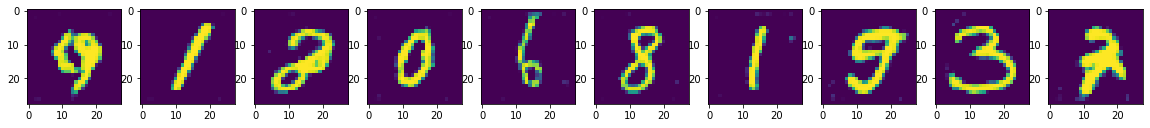

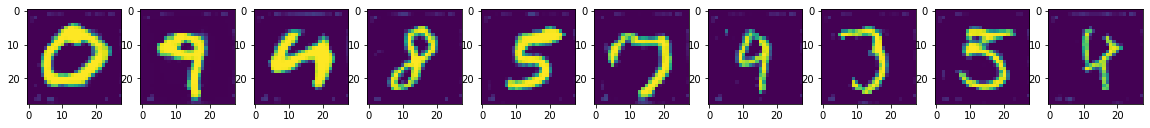

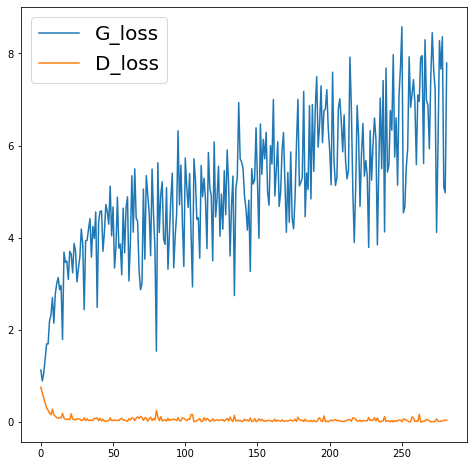

In [13]:

with torch.no_grad():

    noise_z = torch.randn(10, latent_dim)
    if device:
        noise_z = noise_z.to(device)
    fake_data = G(noise_z)
    plt.figure(figsize=(20,4))
    for i in range(10):
        ax = plt.subplot(1, 10, i+1)
        plt.imshow(fake_data.data.cpu().numpy()[i,:,:])
    # sample 2
    noise_z = torch.randn(10, latent_dim)
    if device:
        noise_z = noise_z.to(device)
    fake_data = G(noise_z)
    plt.figure(figsize=(20,4))
    for i in range(10):
        ax = plt.subplot(1, 10, i+1)
        plt.imshow(fake_data.data.cpu().numpy()[i,:,:])
    # get loss plot
    plt.figure(figsize =(8 ,8))
    plt.plot(np.arange(0, len(G_loss_log)), G_loss_log, label='G_loss')
    plt.plot(np.arange(0, len(D_loss_log)), D_loss_log, label='D_loss')
    plt.legend(fontsize=20)

In [5]:
'''
conditional gan
use label with nn.Embedding
'''
class cDis_p1(nn.Module):
    def __init__(self):
        super(cDis_p1, self).__init__()
        # img
        self.conv_1 = nn.Conv2d(1, 32, kernel_size = 7, stride = 1) # [22, 22]
        self.conv_1_bn = nn.BatchNorm2d(32)

        
        self.conv_2 = nn.Conv2d(32, 64, kernel_size = 7, stride = 1) # [16, 16]
        self.conv_2_bn = nn.BatchNorm2d(64)
        self.conv_2_PReLu = nn.PReLU()
        
        self.conv_3 = nn.Conv2d(64+16, 128, kernel_size = 7, stride = 1) # [10, 10]
        self.conv_3_bn = nn.BatchNorm2d(128)

        # label
        self.deconv_label_1 = nn.ConvTranspose2d(32, 16, kernel_size = 16, stride = 1)
        self.deconv_label_1_bn = nn.BatchNorm2d(16)

        self.globel_pool_layer = nn.AdaptiveMaxPool2d(1)
        
        self.fc_1 = nn.Linear(128, 32)
        self.fc_2 = nn.Linear(32, 1)
    def forward(self, data, label):
        bs, H, W = data.size()
        x = data.view(bs, 1, H, W)
        
        x = nn.LeakyReLU(0.2)(self.conv_1_bn (self.conv_1(x)))
        x = nn.LeakyReLU(0.2)(self.conv_2_bn (self.conv_2(x)))
        
        y = label.view(bs, 32, 1, 1)
        y = nn.LeakyReLU(0.2)(self.deconv_label_1_bn(self.deconv_label_1(y)))
        
        cat_data = torch.cat([x, y], dim=1)
        feature =  nn.LeakyReLU(0.2)(self.conv_3_bn (self.conv_3(cat_data)))

        pred_out =  self.globel_pool_layer(feature).squeeze()

        pred_out = torch.sigmoid(self.fc_1(pred_out))
        pred_out = torch.sigmoid(self.fc_2(pred_out)).squeeze()
        
        return pred_out
    
class cGen_p1(nn.Module):
    def __init__(self, noise_dim, label_dim):
        super(cGen_p1, self).__init__()
        self.noise_dim = noise_dim
        self.label_dim = label_dim
        
        self.label_emb = nn.Embedding(self.label_dim, 32)
        
        self.deconv_1 = nn.ConvTranspose2d(self.noise_dim+32, 64, kernel_size = 10, stride = 1)
        self.deconv_1_bn = nn.BatchNorm2d(64)
        
        self.deconv_2 = nn.ConvTranspose2d(64, 32, kernel_size = 7, stride = 1)
        self.deconv_2_bn = nn.BatchNorm2d(32)
        
        self.deconv_3 = nn.ConvTranspose2d(32, 16, kernel_size = 5, stride = 1)
        self.deconv_3_bn = nn.BatchNorm2d(16)
        
        self.deconv_4 = nn.ConvTranspose2d(16, 8, kernel_size = 5, stride = 1)
        self.deconv_4_bn = nn.BatchNorm2d(8)
        
        self.deconv_5 = nn.ConvTranspose2d(8, 1, kernel_size = 5, stride = 1)
        self.deconv_5_bn = nn.BatchNorm2d(1)
        
    def forward(self, noise_z, label):
        bs, C = noise_z.size()
        x = noise_z
        y = nn.Softmax(dim=-1)(self.label_emb(label))
        
        data = torch.cat([x, y], dim=1)
        
        data = data.view(bs, 132, 1, 1)
        
        feature = nn.LeakyReLU(0.2)(self.deconv_1_bn(self.deconv_1(data)))
        
        feature = nn.LeakyReLU(0.2)(self.deconv_2_bn(self.deconv_2(feature)))
        feature = nn.LeakyReLU(0.2)(self.deconv_3_bn(self.deconv_3(feature)))
        feature = nn.LeakyReLU(0.2)(self.deconv_4_bn(self.deconv_4(feature)))
        feature = nn.LeakyReLU(0.2)(self.deconv_5_bn(self.deconv_5(feature)))

        fake_data = torch.tanh(feature.squeeze())
        
        return fake_data , y

In [9]:
EPOCH = 30
BATCH_SIZE = 64
latent_dim = 100

bce_loss = nn.BCELoss()
cD_p1 = cDis_p1()
cG_p1 = cGen_p1(noise_dim = latent_dim, label_dim = 10)
if torch.cuda.is_available():
    bce_loss.cuda()
    cD_p1.cuda()
    cG_p1.cuda()
optim_cD_p1 = torch.optim.Adam(cD_p1.parameters(), lr = 0.0001)
optim_cG_p1 = torch.optim.Adam(cG_p1.parameters(), lr = 0.0001)
'''
Training
'''
train_data_dataset = torch.utils.data.TensorDataset(train_data, train_label)
train_dataloader = torch.utils.data.DataLoader(dataset = train_data_dataset, batch_size = BATCH_SIZE, shuffle=True)

G_loss_log = []
D_loss_log = []
log_index = 0

for epoch in range(EPOCH):
    for n, (data, label) in enumerate(train_dataloader):
        real_valid = torch.ones(data.size(0))
        fake_valid = torch.zeros(data.size(0))
        z = torch.randn(data.size(0), latent_dim)
        real_data = data
        real_label = label
#         fake_label = torch.from_numpy(np.random.randint(0, 10, (data.size(0), 1))).type(torch.FloatTensor)
#         fake_label = torch.from_numpy(np.random.randint(0, 10, (data.size(0), 1))).type(torch.LongTensor)        
        if torch.cuda.is_available():
            real_valid = real_valid.cuda()
            fake_valid = fake_valid.cuda()
            z = z.cuda()
            real_data = real_data.cuda()
            real_label = real_label.cuda()
#             fake_label = fake_label.cuda()
        # === train gen ===
        optim_cG_p1.zero_grad()
        fake_data , label_emb = cG_p1(z, real_label) # use real label
        
        cG_loss = bce_loss( cD_p1(fake_data, label_emb), real_valid) # judge fake img is real
        cG_loss.backward()
        optim_cG_p1.step()

        # === train dis ===
        optim_cD_p1.zero_grad()
        real_loss = bce_loss(cD_p1(real_data, label_emb.detach()),          real_valid) # judge real img is real
        fake_loss = bce_loss(cD_p1(fake_data.detach(), label_emb.detach()), fake_valid)
        
        cD_loss = (real_loss+fake_loss)/2
        cD_loss.backward()
        optim_cD_p1.step()
        if log_index % 100 == 0:
            G_loss_log.append(cG_loss)
            D_loss_log.append(cD_loss)
        log_index += 1
    with torch.no_grad():
        print('Epoch[{}] >> cG_loss : {:.4f}, cD_loss : {:.4f}'.format(epoch+1, cG_loss.item(), cD_loss.item()))

Epoch[1] >> cG_loss : 2.6189, cD_loss : 0.0736
Epoch[2] >> cG_loss : 3.4358, cD_loss : 0.0346
Epoch[3] >> cG_loss : 1.7046, cD_loss : 0.3727
Epoch[4] >> cG_loss : 3.1123, cD_loss : 0.3274
Epoch[5] >> cG_loss : 2.4447, cD_loss : 0.0760
Epoch[6] >> cG_loss : 4.5670, cD_loss : 0.1353
Epoch[7] >> cG_loss : 4.3316, cD_loss : 0.0106
Epoch[8] >> cG_loss : 2.9527, cD_loss : 0.0333
Epoch[9] >> cG_loss : 3.0467, cD_loss : 0.0446
Epoch[10] >> cG_loss : 1.4951, cD_loss : 0.1575
Epoch[11] >> cG_loss : 3.0088, cD_loss : 0.0588
Epoch[12] >> cG_loss : 3.2993, cD_loss : 0.0977
Epoch[13] >> cG_loss : 0.6322, cD_loss : 0.4916
Epoch[14] >> cG_loss : 4.9739, cD_loss : 0.0078
Epoch[15] >> cG_loss : 1.9638, cD_loss : 0.1111
Epoch[16] >> cG_loss : 4.6557, cD_loss : 0.0213
Epoch[17] >> cG_loss : 2.0765, cD_loss : 0.2885
Epoch[18] >> cG_loss : 4.7929, cD_loss : 0.0839
Epoch[19] >> cG_loss : 3.4730, cD_loss : 0.0444
Epoch[20] >> cG_loss : 3.1913, cD_loss : 0.0614
Epoch[21] >> cG_loss : 2.5437, cD_loss : 0.0588
E

tensor([0, 6, 9, 0, 1, 5, 9, 7, 3, 4], device='cuda:0')
torch.Size([10, 28, 28])
tensor([6, 3, 5, 5, 6, 0, 4, 1, 9, 5], device='cuda:0')
torch.Size([10, 28, 28])


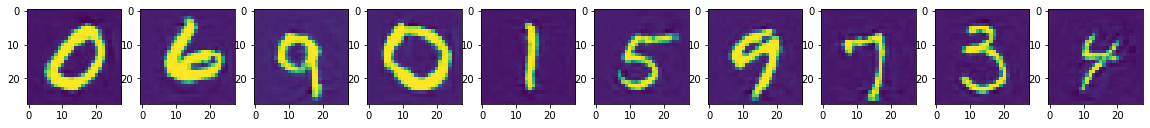

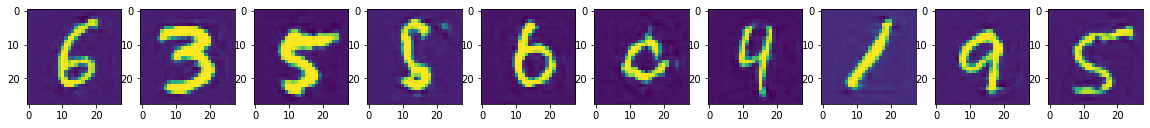

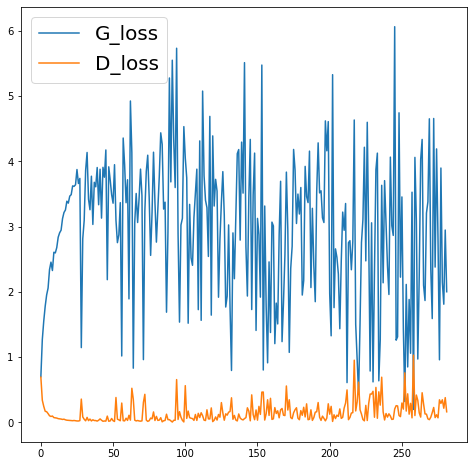

In [10]:

with torch.no_grad():
    # sample 1
    z = torch.randn(10, latent_dim)
    label = test_label[10:20]
    
    if device:
        z = z.to(device)
        label = label.to(device)
    print(label[:10])
    fake_data ,_= cG_p1(z, label)
    print(fake_data.size())
    plt.figure(figsize=(20,4))
    for i in range(10):
        ax = plt.subplot(1, 10, i+1)
        plt.imshow(fake_data.data.cpu().numpy()[i,:,:])
    # sample 2
    z = torch.randn(10, latent_dim)
    label = test_label[50:60]
    
    if device:
        z = z.to(device)
        label = label.to(device)
    print(label[:10])
    fake_data ,_= cG_p1(z, label)
    print(fake_data.size())
    plt.figure(figsize=(20,4))
    for i in range(10):
        ax = plt.subplot(1, 10, i+1)
        plt.imshow(fake_data.data.cpu().numpy()[i,:,:])
    # get loss plot
    plt.figure(figsize =(8 ,8))
    plt.plot(np.arange(0, len(G_loss_log)), G_loss_log, label='G_loss')
    plt.plot(np.arange(0, len(D_loss_log)), D_loss_log, label='D_loss')
    plt.legend(fontsize=20)

In [14]:
'''
conditional gan
use label with nn.Embedding
use fc_layer for Flatten feature
'''
class cDis_p2(nn.Module):
    def __init__(self):
        super(cDis_p2, self).__init__()
        # img
        self.conv_1 = nn.Conv2d(1, 32, kernel_size = 7, stride = 1) # [22, 22]
        self.conv_1_bn = nn.BatchNorm2d(32)

        
        self.conv_2 = nn.Conv2d(32, 64, kernel_size = 7, stride = 1) # [16, 16]
        self.conv_2_bn = nn.BatchNorm2d(64)
        self.conv_2_PReLu = nn.PReLU()
        
        self.conv_3 = nn.Conv2d(64+16, 128, kernel_size = 7, stride = 1) # [10, 10]
        self.conv_3_bn = nn.BatchNorm2d(128)

        # label
        self.deconv_label_1 = nn.ConvTranspose2d(32, 16, kernel_size = 16, stride = 1)
        self.deconv_label_1_bn = nn.BatchNorm2d(16)

#         self.globel_pool_layer = nn.AdaptiveMaxPool2d(1)
        
        self.fc_1 = nn.Linear(128*10*10, 512)
        self.fc_2 = nn.Linear(512, 128)
        self.fc_3 = nn.Linear(128, 1)
    def forward(self, data, label):
        bs, H, W = data.size()
        x = data.view(bs, 1, H, W)
        
        x = nn.LeakyReLU(0.2)(self.conv_1_bn (self.conv_1(x)))
        x = nn.LeakyReLU(0.2)(self.conv_2_bn (self.conv_2(x)))
        
        y = label.view(bs, 32, 1, 1)
        y = nn.LeakyReLU(0.2)(self.deconv_label_1_bn(self.deconv_label_1(y)))
        
        cat_data = torch.cat([x, y], dim=1)
        feature =  nn.LeakyReLU(0.2)(self.conv_3_bn (self.conv_3(cat_data)))
        feature = feature.view(bs, -1)

#         pred_out =  self.globel_pool_layer(feature).squeeze()

        pred_out = torch.sigmoid(self.fc_1(feature))
        pred_out = torch.sigmoid(self.fc_2(pred_out))
        pred_out = torch.sigmoid(self.fc_3(pred_out)).squeeze()
        return pred_out
    
class cGen_p2(nn.Module):
    def __init__(self, noise_dim, label_dim):
        super(cGen_p2, self).__init__()
        self.noise_dim = noise_dim
        self.label_dim = label_dim
        
        self.label_emb = nn.Embedding(self.label_dim, 32)
        
        self.deconv_1 = nn.ConvTranspose2d(self.noise_dim+self.label_dim, 64, kernel_size = 10, stride = 1)
        self.deconv_1_bn = nn.BatchNorm2d(64)
        
        self.deconv_2 = nn.ConvTranspose2d(64, 32, kernel_size = 7, stride = 1)
        self.deconv_2_bn = nn.BatchNorm2d(32)
        
        self.deconv_3 = nn.ConvTranspose2d(32, 16, kernel_size = 5, stride = 1)
        self.deconv_3_bn = nn.BatchNorm2d(16)
        
        self.deconv_4 = nn.ConvTranspose2d(16, 8, kernel_size = 5, stride = 1)
        self.deconv_4_bn = nn.BatchNorm2d(8)
        
        self.deconv_5 = nn.ConvTranspose2d(8, 1, kernel_size = 5, stride = 1)
        self.deconv_5_bn = nn.BatchNorm2d(1)
        
    def forward(self, noise_z, label):
        bs, C = noise_z.size()
        x = noise_z
        y = nn.Softmax(dim=-1)(self.label_emb(label))
        
        data = torch.cat([x, y], dim=1)
        
        data = data.view(bs, 132, 1, 1)
        
        feature = nn.LeakyReLU(0.2)(self.deconv_1_bn(self.deconv_1(data)))
        
        feature = nn.LeakyReLU(0.2)(self.deconv_2_bn(self.deconv_2(feature)))
        feature = nn.LeakyReLU(0.2)(self.deconv_3_bn(self.deconv_3(feature)))
        feature = nn.LeakyReLU(0.2)(self.deconv_4_bn(self.deconv_4(feature)))
        feature = nn.LeakyReLU(0.2)(self.deconv_5_bn(self.deconv_5(feature)))

        fake_data = torch.tanh(feature.squeeze())
        
        return fake_data , y

In [15]:
EPOCH = 30
BATCH_SIZE = 64
latent_dim = 100

bce_loss = nn.BCELoss()
cD_p2 = cDis_p2()
cG_p2 = cGen_p2(noise_dim = latent_dim, label_dim = 32)
if torch.cuda.is_available():
    bce_loss.cuda()
    cD_p2.cuda()
    cG_p2.cuda()
optim_cD_p2 = torch.optim.Adam(cD_p2.parameters(), lr = 0.0001)
optim_cG_p2 = torch.optim.Adam(cG_p2.parameters(), lr = 0.0001)
'''
Training
'''
train_data_dataset = torch.utils.data.TensorDataset(train_data, train_label)
train_dataloader = torch.utils.data.DataLoader(dataset = train_data_dataset, batch_size = BATCH_SIZE, shuffle=True)

G_loss_log = []
D_loss_log = []
log_index = 0

for epoch in range(EPOCH):
    for n, (data, label) in enumerate(train_dataloader):
        real_valid = torch.ones(data.size(0))
        fake_valid = torch.zeros(data.size(0))
        z = torch.randn(data.size(0), latent_dim)
        real_data = data
        real_label = label
#         fake_label = torch.from_numpy(np.random.randint(0, 10, (data.size(0), 1))).type(torch.FloatTensor)
#         fake_label = torch.from_numpy(np.random.randint(0, 10, (data.size(0), 1))).type(torch.LongTensor)        
        if torch.cuda.is_available():
            real_valid = real_valid.cuda()
            fake_valid = fake_valid.cuda()
            z = z.cuda()
            real_data = real_data.cuda()
            real_label = real_label.cuda()
#             fake_label = fake_label.cuda()
        # === train gen ===
        optim_cG_p2.zero_grad()
        fake_data , label_emb = cG_p2(z, real_label) # use real label
        
        cG_loss = bce_loss( cD_p2(fake_data, label_emb), real_valid) # judge fake img is real
        cG_loss.backward()
        optim_cG_p2.step()

        # === train dis ===
        optim_cD_p2.zero_grad()
        real_loss = bce_loss(cD_p2(real_data, label_emb.detach()),          real_valid) # judge real img is real
        fake_loss = bce_loss(cD_p2(fake_data.detach(), label_emb.detach()), fake_valid)
        
        cD_loss = (real_loss+fake_loss)/2
        cD_loss.backward()
        optim_cD_p2.step()
        if log_index % 100 == 0:
            G_loss_log.append(cG_loss)
            D_loss_log.append(cD_loss)
        log_index += 1
    with torch.no_grad():
        print('Epoch[{}] >> cG_loss : {:.4f}, cD_loss : {:.4f}'.format(epoch+1, cG_loss.item(), cD_loss.item()))

Epoch[1] >> cG_loss : 3.6141, cD_loss : 0.0289
Epoch[2] >> cG_loss : 5.3476, cD_loss : 0.0061
Epoch[3] >> cG_loss : 6.0147, cD_loss : 0.0022
Epoch[4] >> cG_loss : 4.1166, cD_loss : 0.0278
Epoch[5] >> cG_loss : 6.6606, cD_loss : 0.0153
Epoch[6] >> cG_loss : 3.3609, cD_loss : 0.0763
Epoch[7] >> cG_loss : 5.4685, cD_loss : 0.0068
Epoch[8] >> cG_loss : 2.1306, cD_loss : 0.2469
Epoch[9] >> cG_loss : 4.8758, cD_loss : 0.0664
Epoch[10] >> cG_loss : 4.2775, cD_loss : 0.2924
Epoch[11] >> cG_loss : 1.8649, cD_loss : 0.1843
Epoch[12] >> cG_loss : 3.0754, cD_loss : 0.4180
Epoch[13] >> cG_loss : 0.4958, cD_loss : 0.7397
Epoch[14] >> cG_loss : 2.1450, cD_loss : 0.1898
Epoch[15] >> cG_loss : 2.6017, cD_loss : 0.2426
Epoch[16] >> cG_loss : 3.3678, cD_loss : 0.8689
Epoch[17] >> cG_loss : 2.2326, cD_loss : 0.1231
Epoch[18] >> cG_loss : 0.5653, cD_loss : 0.9054
Epoch[19] >> cG_loss : 3.3780, cD_loss : 0.7826
Epoch[20] >> cG_loss : 3.8445, cD_loss : 0.4986
Epoch[21] >> cG_loss : 1.0627, cD_loss : 0.3881
E

tensor([0, 6, 9, 0, 1, 5, 9, 7, 3, 4], device='cuda:0')
torch.Size([10, 28, 28])
tensor([6, 3, 5, 5, 6, 0, 4, 1, 9, 5], device='cuda:0')
torch.Size([10, 28, 28])


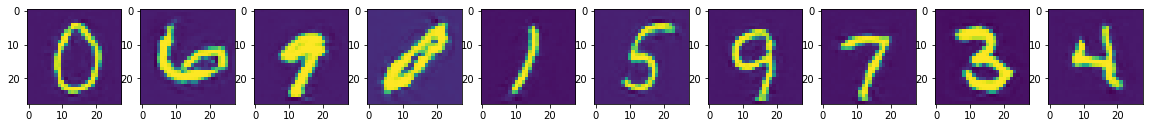

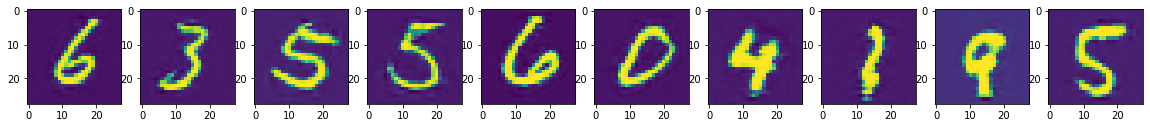

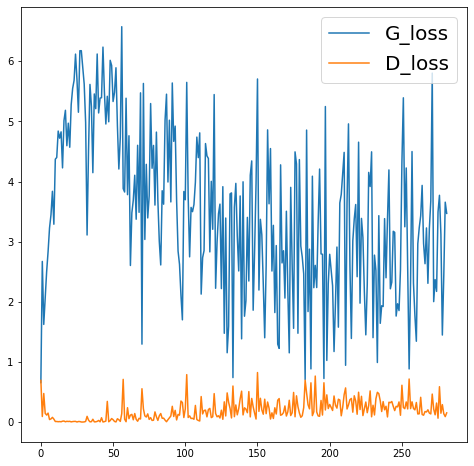

In [16]:

with torch.no_grad():
    # sample 1
    z = torch.randn(10, latent_dim)
    label = test_label[10:20]
    if device:
        z = z.to(device)
        label = label.to(device)
    print(label[:10])
    fake_data ,_= cG_p2(z, label)
    print(fake_data.size())
    plt.figure(figsize=(20,4))
    for i in range(10):
        ax = plt.subplot(1, 10, i+1)
        plt.imshow(fake_data.data.cpu().numpy()[i,:,:])
        
     # sample 2
    z = torch.randn(10, latent_dim)
    label = test_label[50:60]
    if device:
        z = z.to(device)
        label = label.to(device)
    print(label[:10])
    fake_data ,_= cG_p2(z, label)
    print(fake_data.size())
    plt.figure(figsize=(20,4))
    for i in range(10):
        ax = plt.subplot(1, 10, i+1)
        plt.imshow(fake_data.data.cpu().numpy()[i,:,:])
        
    # get loss plot
    plt.figure(figsize =(8 ,8))
    plt.plot(np.arange(0, len(G_loss_log)), G_loss_log, label='G_loss')
    plt.plot(np.arange(0, len(D_loss_log)), D_loss_log, label='D_loss')
    plt.legend(fontsize=20)

In [18]:
'''
conditional gan
use label no nn.Embedding
use cus embedding

********

********


'''
class cus_FFN_emb(nn.Module):
    def __init__(self, out_emb_dim = 32):
        super(cus_FFN_emb, self).__init__()
        self.fc_1 = nn.Linear(1, 512, bias = False)
        self.fc_2_1 = nn.Linear(512, 128, bias = False)
        self.fc_2_2 = nn.Linear(128, out_emb_dim, bias = False)
        self.fc_3 = nn.Linear(out_emb_dim, 1, bias = False)
    def forward(self, label):
        y = label
        y = torch.relu(self.fc_1(y))
        y = torch.relu(self.fc_2_1(y))
        emb = torch.relu(self.fc_2_2(y))
        out = (self.fc_3(emb))
        
        return out, emb
# ---------------------------------------
class cDis_p3(nn.Module):
    def __init__(self):
        super(cDis_p3, self).__init__()
        # img
        self.conv_1 = nn.Conv2d(1, 32, kernel_size = 7, stride = 1) # [22, 22]
        self.conv_1_bn = nn.BatchNorm2d(32)
        self.conv_2 = nn.Conv2d(32, 64, kernel_size = 7, stride = 1) # [16, 16]
        self.conv_2_bn = nn.BatchNorm2d(64)
        self.conv_2_PReLu = nn.PReLU()
        
        self.conv_3 = nn.Conv2d(64+16, 128, kernel_size = 7, stride = 1) # [10, 10]
        self.conv_3_bn = nn.BatchNorm2d(128)

        # label
        self.deconv_label_1 = nn.ConvTranspose2d(32, 16, kernel_size = 16, stride = 1)
        self.deconv_label_1_bn = nn.BatchNorm2d(16)

        self.globel_pool_layer = nn.AdaptiveMaxPool2d(1)
        
        self.fc_1 = nn.Linear(128, 32)
        self.fc_2 = nn.Linear(32, 1)
    def forward(self, data, label):
        bs, H, W = data.size()
        x = data.view(bs, 1, H, W)
        
        x = nn.LeakyReLU(0.2)(self.conv_1_bn (self.conv_1(x)))
        x = nn.LeakyReLU(0.2)(self.conv_2_bn (self.conv_2(x)))
        
        y = label.view(bs, 32, 1, 1)
        y = nn.LeakyReLU(0.2)(self.deconv_label_1_bn(self.deconv_label_1(y)))
        
        cat_data = torch.cat([x, y], dim=1)
        feature =  nn.LeakyReLU(0.2)(self.conv_3_bn (self.conv_3(cat_data)))
        feature =  self.globel_pool_layer(feature).squeeze()

        pred_out = torch.sigmoid(self.fc_1(feature))
        pred_out = torch.sigmoid(self.fc_2(pred_out)).squeeze()

        return pred_out
    
class cGen_p3(nn.Module):
    def __init__(self, noise_dim, label_dim):
        super(cGen_p3, self).__init__()
        self.noise_dim = noise_dim
        self.label_dim = label_dim
        
        self.deconv_1 = nn.ConvTranspose2d(self.noise_dim+self.label_dim, 64, kernel_size = 10, stride = 1)
        self.deconv_1_bn = nn.BatchNorm2d(64)
        
        self.deconv_2 = nn.ConvTranspose2d(64, 32, kernel_size = 7, stride = 1)
        self.deconv_2_bn = nn.BatchNorm2d(32)
        
        self.deconv_3 = nn.ConvTranspose2d(32, 16, kernel_size = 5, stride = 1)
        self.deconv_3_bn = nn.BatchNorm2d(16)
        
        self.deconv_4 = nn.ConvTranspose2d(16, 8, kernel_size = 5, stride = 1)
        self.deconv_4_bn = nn.BatchNorm2d(8)
        
        self.deconv_5 = nn.ConvTranspose2d(8, 1, kernel_size = 5, stride = 1)
        self.deconv_5_bn = nn.BatchNorm2d(1)
        
    def forward(self, noise_z, label):
        bs, C = noise_z.size()
        x = noise_z
        y = nn.Softmax(dim=-1)(label) 
        
        data = torch.cat([x, y], dim=1)
        
        data = data.view(bs, 132, 1, 1)
        
        feature = nn.LeakyReLU(0.2)(self.deconv_1_bn(self.deconv_1(data)))
        
        feature = nn.LeakyReLU(0.2)(self.deconv_2_bn(self.deconv_2(feature)))
        feature = nn.LeakyReLU(0.2)(self.deconv_3_bn(self.deconv_3(feature)))
        feature = nn.LeakyReLU(0.2)(self.deconv_4_bn(self.deconv_4(feature)))
        feature = nn.LeakyReLU(0.2)(self.deconv_5_bn(self.deconv_5(feature)))

        fake_data = torch.tanh(feature.squeeze())
        
        return fake_data 

In [19]:
EPOCH = 30
BATCH_SIZE = 64
latent_dim = 100

bce_loss = nn.BCELoss()
mse_loss = nn.MSELoss()
cD_p3 = cDis_p3()
cG_p3 = cGen_p3(noise_dim = latent_dim, label_dim = 32)
Cus_Emb = cus_FFN_emb(out_emb_dim = 32)

if torch.cuda.is_available():
    bce_loss.cuda()
    mse_loss.cuda()
    cD_p3.cuda()
    cG_p3.cuda()
    Cus_Emb.to(device)
optim_cD_p3 = torch.optim.Adam(cD_p3.parameters(), lr = 0.0001)
optim_cG_p3 = torch.optim.Adam(cG_p3.parameters(), lr = 0.0001)
optim_emb = torch.optim.Adam(Cus_Emb.parameters(), lr = 0.0001)

train_data_dataset = torch.utils.data.TensorDataset(train_data, train_label)
train_dataloader = torch.utils.data.DataLoader(dataset = train_data_dataset, batch_size = BATCH_SIZE, shuffle=True)
G_loss_log = []
D_loss_log = []
log_index = 0
'''
Training emb
'''
for epoch in range(15):
    for n, (data, label) in enumerate(train_dataloader):
        optim_emb.zero_grad()
        real_label = label.type(torch.FloatTensor)
        if torch.cuda.is_available():
            real_label = real_label.to(device)
        real_label = real_label.reshape(len(real_label), 1)
        pred_label, emb_dim = Cus_Emb(real_label)
        loss = mse_loss(pred_label, real_label)
        loss.backward()
        optim_emb.step()
    with torch.no_grad():
        print('epoch :[{}] : loss : {:.50f}'.format(epoch+1, loss.item()))
with torch.no_grad():
    label_valid = test_label[30:40]
    label_valid = label_valid.reshape(len(label_valid), 1).type(torch.FloatTensor)
    if device:
        label_valid = label_valid.to(device)
    pred_label, _ = Cus_Emb(label_valid)
    print(test_label[30:40])
    print(pred_label.size())
    print(pred_label.squeeze())

'''
Training gan
'''
for epoch in range(EPOCH):
    for n, (data, label) in enumerate(train_dataloader):
        real_valid = torch.ones(data.size(0))
        fake_valid = torch.zeros(data.size(0))
        z = torch.randn(data.size(0), latent_dim)
        real_data = data
        real_label = label.type(torch.FloatTensor).reshape(len(label), 1)
#         fake_label = torch.from_numpy(np.random.randint(0, 10, (data.size(0), 1))).type(torch.FloatTensor)
#         fake_label = torch.from_numpy(np.random.randint(0, 10, (data.size(0), 1))).type(torch.LongTensor)        
        if torch.cuda.is_available():
            real_valid = real_valid.cuda()
            fake_valid = fake_valid.cuda()
            z = z.cuda()
            real_data = real_data.cuda()
            real_label = real_label.cuda()
#             fake_label = fake_label.cuda()
        # === get cus emb ===
        _, real_label_emb = Cus_Emb(real_label)
        # === train gen ===
        optim_cG_p3.zero_grad()
        fake_data  = cG_p3(z, real_label_emb.detach()) # use real label
        
        cG_loss = bce_loss( cD_p3(fake_data, real_label_emb.detach()), real_valid) # judge fake img is real
        cG_loss.backward()
        optim_cG_p3.step()

        # === train dis ===
        optim_cD_p3.zero_grad()
        real_loss = bce_loss(cD_p3(real_data, real_label_emb.detach()),          real_valid) # judge real img is real
        fake_loss = bce_loss(cD_p3(fake_data.detach(), real_label_emb.detach()), fake_valid)
        
        cD_loss = (real_loss+fake_loss)/2
        cD_loss.backward()
        optim_cD_p3.step()
        
        if log_index % 100 == 0:
            G_loss_log.append(cG_loss)
            D_loss_log.append(cD_loss)
        log_index += 1
    with torch.no_grad():
        print('Epoch[{}] >> cG_loss : {:.4f}, cD_loss : {:.4f}'.format(epoch+1, cG_loss.item(), cD_loss.item()))

epoch :[1] : loss : 0.00000000000004796163466380676254630088806152343750
epoch :[2] : loss : 0.00000000000004440892098500626161694526672363281250
epoch :[3] : loss : 0.00000000000007460698725481051951646804809570312500
epoch :[4] : loss : 0.00000000000003552713678800500929355621337890625000
epoch :[5] : loss : 0.00000000000001953992523340275511145591735839843750
epoch :[6] : loss : 0.00000000000014921397450962103903293609619140625000
epoch :[7] : loss : 0.00000000000019539925233402755111455917358398437500
epoch :[8] : loss : 0.00000000000008881784197001252323389053344726562500
epoch :[9] : loss : 0.00000000000000000000000000000000000000000000000000
epoch :[10] : loss : 0.00000000000000000000000000000000000000000000000000
epoch :[11] : loss : 0.00000000000000000000000000000000000000000000000000
epoch :[12] : loss : 0.00000000000000000000000000000000000000000000000000
epoch :[13] : loss : 0.00000000000000000000000000000000000000000000000000
epoch :[14] : loss : 0.000000000000000000000000

tensor([0., 6., 9., 0., 1., 5., 9., 7., 3., 4.], device='cuda:0')
tensor([0., 6., 9., 0., 1., 5., 9., 7., 3., 4.], device='cuda:0')
torch.Size([10, 28, 28])
tensor([6., 3., 5., 5., 6., 0., 4., 1., 9., 5.], device='cuda:0')
tensor([6., 3., 5., 5., 6., 0., 4., 1., 9., 5.], device='cuda:0')
torch.Size([10, 28, 28])


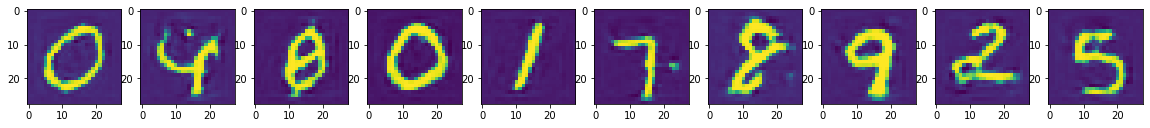

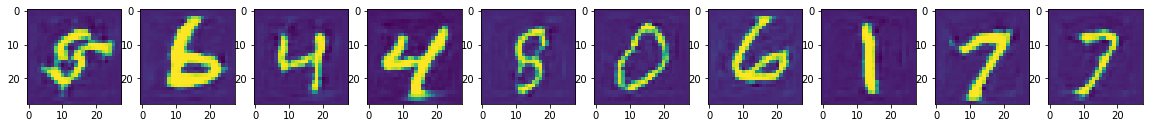

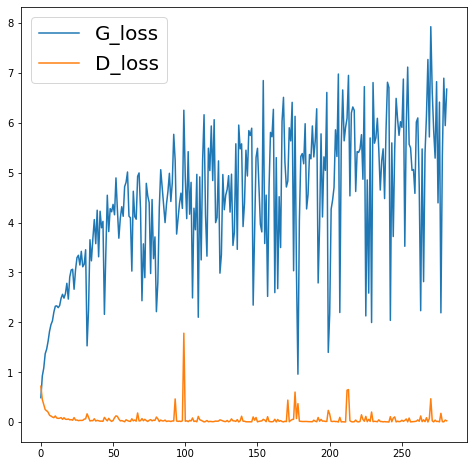

In [20]:

with torch.no_grad():
    # sample 1
    z = torch.randn(10, latent_dim)
    label = test_label[10:20].type(torch.FloatTensor)
    if device:
        z = z.to(device)
        label = label.to(device)
        
    pre_label, test_label_emb = Cus_Emb(label.reshape(len(label), 1))
    print(label[:10])
    print(pre_label.squeeze())
    fake_data = cG_p3(z, test_label_emb.detach())
    print(fake_data.size())
    plt.figure(figsize=(20,4))
    for i in range(10):
        ax = plt.subplot(1, 10, i+1)
        plt.imshow(fake_data.data.cpu().numpy()[i,:,:])
    
    # sample 2
    z = torch.randn(10, latent_dim)
    label = test_label[50:60].type(torch.FloatTensor)
    if device:
        z = z.to(device)
        label = label.to(device)
        
    pre_label, test_label_emb = Cus_Emb(label.reshape(len(label), 1))
    print(label[:10])
    print(pre_label.squeeze())
    fake_data = cG_p3(z, test_label_emb.detach())
    print(fake_data.size())
    plt.figure(figsize=(20,4))
    for i in range(10):
        ax = plt.subplot(1, 10, i+1)
        plt.imshow(fake_data.data.cpu().numpy()[i,:,:])
    # get loss plot
    plt.figure(figsize =(8 ,8))
    plt.plot(np.arange(0, len(G_loss_log)), G_loss_log, label='G_loss')
    plt.plot(np.arange(0, len(D_loss_log)), D_loss_log, label='D_loss')
    plt.legend(fontsize=20)

In [4]:
'''
引用
DETR的天馬行空：用Transformer走出Object Detection簡潔Pipeline

PE(pos, 2i)   = sin(pos / 10000^(2i/d_model))
PE(pos, 2i+1) = cos(pos / 10000^(2i/d_model))

pos就是輸入label資料
例如 翻譯中 vocabulary 長度為5 
    
所以 使用sequence 的shape:
                        以數字label為例 ,上述有使用 nn.embedding 轉換 shape 1 >> 32 
                        input:[Bs, seq_len, data/label_len] ; output : [BS, seq_len, emb_len]
                              [ 32,      6,      1]  >>                [32,       6,     32]  
    沒使用sequence 的shape:
                        input:[Bs,    data/label_len] ; output : [BS,  emb_len]
                              [32,       1          ]  >>        [32,       32]  
                        
'''


def positional_encoding_with_seq(ori_pos, emb_len, d_model):
    i = np.arange(emb_len).reshape(1, emb_len)

    angle_rates = 1 / np.power(10000, 2*(i//2)/d_model)
    angle_rads = ori_pos * angle_rates

    angle_rads[:, :, 0::2] = np.sin(angle_rads[:, :, 0::2])
    angle_rads[:, :, 1::2] = np.cos(angle_rads[:, :, 1::2])
    
    return angle_rads
    
def positional_encoding_no_seq(ori_pos, emb_len, d_model):
    i = np.arange(emb_len).reshape(1, emb_len)

    angle_rates = 1 / np.power(10000, 2*(i//2)/d_model)
    angle_rads = ori_pos * angle_rates

    angle_rads[ :, 0::2] = np.sin(angle_rads[:, 0::2])
    angle_rads[ :, 1::2] = np.cos(angle_rads[:, 1::2])

    return angle_rads
    
if __name__ == '__main__':
    batch_size = 2
    seq_len = 5
    # -----------------
#     fake_label = torch.from_numpy(np.random.randint(0, 10, (batch_size, seq_len, 1))).type(torch.LongTensor)
    fake_label = torch.Tensor([[0,9,0,9,8], [8,0,2,2,8]]).reshape(2, 5, 1)
    
    fake_label = fake_label.data.numpy()
    print(fake_label)
    print(fake_label.shape)
    label_emb = positional_encoding_with_seq(fake_label, emb_len = 5, d_model=512)
    print(label_emb)
    print(label_emb.shape)
    # ------------------
#     fake_label = torch.from_numpy(np.random.randint(0, 10, (batch_size, 1))).type(torch.LongTensor)
    fake_label = torch.Tensor([0,9,0,9,8]).reshape(5, 1)

    fake_label = fake_label.data.numpy()
    print(fake_label)
    print(fake_label.shape)
    label_emb = positional_encoding_no_seq(fake_label, emb_len = 5, d_model=512)
    print(label_emb)
    print(label_emb.shape)

[[[0.]
  [9.]
  [0.]
  [9.]
  [8.]]

 [[8.]
  [0.]
  [2.]
  [2.]
  [8.]]]
(2, 5, 1)
[[[ 0.          0.          0.          0.          0.        ]
  [-0.91113026 -0.91113026 -0.73656185 -0.73656185 -0.49789231]
  [ 0.          0.          0.          0.          0.        ]
  [-0.91113026 -0.91113026 -0.73656185 -0.73656185 -0.49789231]
  [ 0.98935825  0.98935825  0.99067264  0.99067264  0.91735771]]

 [[ 0.98935825  0.98935825  0.99067264  0.99067264  0.91735771]
  [ 1.          1.          1.          1.          1.        ]
  [ 0.90929743  0.90929743  0.93641474  0.93641474  0.95814438]
  [-0.41614684 -0.41614684 -0.35089519 -0.35089519 -0.28628544]
  [ 0.98935825  0.98935825  0.99067264  0.99067264  0.91735771]]]
(2, 5, 5)
[[0.]
 [9.]
 [0.]
 [9.]
 [8.]]
(5, 1)
[[ 0.          1.          0.          1.          0.        ]
 [ 0.41211849 -0.91113026  0.6763702  -0.73656185  0.86723886]
 [ 0.          1.          0.          1.          0.        ]
 [ 0.41211849 -0.91113026  0.676370

In [22]:
'''
同p3架構

'''
# ---------------------------------------
class cDis_p4(nn.Module):
    def __init__(self):
        super(cDis_p4, self).__init__()
        # img
        self.conv_1 = nn.Conv2d(1, 32, kernel_size = 7, stride = 1) # [22, 22]
        self.conv_1_bn = nn.BatchNorm2d(32)
        self.conv_2 = nn.Conv2d(32, 64, kernel_size = 7, stride = 1) # [16, 16]
        self.conv_2_bn = nn.BatchNorm2d(64)
        self.conv_2_PReLu = nn.PReLU()
        
        self.conv_3 = nn.Conv2d(64+16, 128, kernel_size = 7, stride = 1) # [10, 10]
        self.conv_3_bn = nn.BatchNorm2d(128)

        # label
        self.deconv_label_1 = nn.ConvTranspose2d(32, 16, kernel_size = 16, stride = 1)
        self.deconv_label_1_bn = nn.BatchNorm2d(16)

        self.globel_pool_layer = nn.AdaptiveMaxPool2d(1)
        
        self.fc_1 = nn.Linear(128, 32)
        self.fc_2 = nn.Linear(32, 1)
    def forward(self, data, label):
        bs, H, W = data.size()
        x = data.view(bs, 1, H, W)
        
        x = nn.LeakyReLU(0.2)(self.conv_1_bn (self.conv_1(x)))
        x = nn.LeakyReLU(0.2)(self.conv_2_bn (self.conv_2(x)))
        
        y = label.view(bs, 32, 1, 1)
        y = nn.LeakyReLU(0.2)(self.deconv_label_1_bn(self.deconv_label_1(y)))
        
        cat_data = torch.cat([x, y], dim=1)
        feature =  nn.LeakyReLU(0.2)(self.conv_3_bn (self.conv_3(cat_data)))
        feature =  self.globel_pool_layer(feature).squeeze()

        pred_out = torch.sigmoid(self.fc_1(feature))
        pred_out = torch.sigmoid(self.fc_2(pred_out)).squeeze()

        return pred_out
    
class cGen_p4(nn.Module):
    def __init__(self, noise_dim, label_dim):
        super(cGen_p4, self).__init__()
        self.noise_dim = noise_dim
        self.label_dim = label_dim
        
        self.deconv_1 = nn.ConvTranspose2d(self.noise_dim+self.label_dim, 64, kernel_size = 10, stride = 1)
        self.deconv_1_bn = nn.BatchNorm2d(64)
        
        self.deconv_2 = nn.ConvTranspose2d(64, 32, kernel_size = 7, stride = 1)
        self.deconv_2_bn = nn.BatchNorm2d(32)
        
        self.deconv_3 = nn.ConvTranspose2d(32, 16, kernel_size = 5, stride = 1)
        self.deconv_3_bn = nn.BatchNorm2d(16)
        
        self.deconv_4 = nn.ConvTranspose2d(16, 8, kernel_size = 5, stride = 1)
        self.deconv_4_bn = nn.BatchNorm2d(8)
        
        self.deconv_5 = nn.ConvTranspose2d(8, 1, kernel_size = 5, stride = 1)
        self.deconv_5_bn = nn.BatchNorm2d(1)
        
    def forward(self, noise_z, label):
        bs, C = noise_z.size()
        x = noise_z
#         y = nn.Softmax(dim=-1)(label) # .......(x)
        y = torch.relu(label) #  .......(o), different with p3.....maybe u can try another
        
        data = torch.cat([x, y], dim=1)
        
        data = data.view(bs, 132, 1, 1)
        
        feature = nn.LeakyReLU(0.2)(self.deconv_1_bn(self.deconv_1(data)))
        
        feature = nn.LeakyReLU(0.2)(self.deconv_2_bn(self.deconv_2(feature)))
        feature = nn.LeakyReLU(0.2)(self.deconv_3_bn(self.deconv_3(feature)))
        feature = nn.LeakyReLU(0.2)(self.deconv_4_bn(self.deconv_4(feature)))
        feature = nn.LeakyReLU(0.2)(self.deconv_5_bn(self.deconv_5(feature)))

        fake_data = torch.tanh(feature.squeeze())
        
        return fake_data 

In [23]:
EPOCH = 30
BATCH_SIZE = 64
latent_dim = 100

bce_loss = nn.BCELoss()
cD_p4 = cDis_p4()
cG_p4 = cGen_p4(noise_dim = latent_dim, label_dim = 32)

if torch.cuda.is_available():
    bce_loss.cuda()
    cD_p4.cuda()
    cG_p4.cuda()
optim_cD_p4 = torch.optim.Adam(cD_p4.parameters(), lr = 0.0001)
optim_cG_p4 = torch.optim.Adam(cG_p4.parameters(), lr = 0.0001)

train_data_dataset = torch.utils.data.TensorDataset(train_data, train_label)
train_dataloader = torch.utils.data.DataLoader(dataset = train_data_dataset, batch_size = BATCH_SIZE, shuffle=True)

G_loss_log = []
D_loss_log = []
log_index = 0
'''
Training gan part4
'''
for epoch in range(EPOCH):
    for n, (data, label) in enumerate(train_dataloader):
        real_valid = torch.ones(data.size(0))
        fake_valid = torch.zeros(data.size(0))
        z = torch.randn(data.size(0), latent_dim)
        real_data = data
        real_label = label
        
        # get emb   [bs, 1] >> [bs, emb_len]
        real_label_emb = positional_encoding_no_seq(ori_pos = (real_label.reshape(len(real_label), 1)).data.numpy(), 
                                                    emb_len = 32, d_model = 512) 
        
        real_label_emb = torch.from_numpy(real_label_emb).type(torch.FloatTensor)
        
        if torch.cuda.is_available():
            real_valid = real_valid.cuda()
            fake_valid = fake_valid.cuda()
            z = z.cuda()
            real_data = real_data.cuda()
            real_label = real_label.cuda()
            real_label_emb = real_label_emb.cuda()
            
        # === train gen ===
        optim_cG_p4.zero_grad()
        fake_data  = cG_p4(z, real_label_emb) # use real label
        
        cG_loss = bce_loss( cD_p4(fake_data, real_label_emb), real_valid) # judge fake img is real
        cG_loss.backward()
        optim_cG_p4.step()

        # === train dis ===
        optim_cD_p4.zero_grad()
        real_loss = bce_loss(cD_p4(real_data, real_label_emb),          real_valid) # judge real img is real
        fake_loss = bce_loss(cD_p4(fake_data.detach(), real_label_emb), fake_valid)
        
        cD_loss = (real_loss+fake_loss)/2
        cD_loss.backward()
        optim_cD_p4.step()
        if log_index % 100 == 0:
            G_loss_log.append(cG_loss)
            D_loss_log.append(cD_loss)
        log_index += 1
    with torch.no_grad():
        print('Epoch[{}] >> cG_loss : {:.4f}, cD_loss : {:.4f}'.format(epoch+1, cG_loss.item(), cD_loss.item()))

Epoch[1] >> cG_loss : 2.6271, cD_loss : 0.0862
Epoch[2] >> cG_loss : 3.5208, cD_loss : 0.0354
Epoch[3] >> cG_loss : 3.9820, cD_loss : 0.0207
Epoch[4] >> cG_loss : 4.6447, cD_loss : 0.0112
Epoch[5] >> cG_loss : 1.5192, cD_loss : 0.2872
Epoch[6] >> cG_loss : 5.0724, cD_loss : 0.0762
Epoch[7] >> cG_loss : 5.6277, cD_loss : 0.0101
Epoch[8] >> cG_loss : 4.6628, cD_loss : 0.0129
Epoch[9] >> cG_loss : 5.4015, cD_loss : 0.0070
Epoch[10] >> cG_loss : 4.9473, cD_loss : 0.0367
Epoch[11] >> cG_loss : 6.2620, cD_loss : 0.0068
Epoch[12] >> cG_loss : 5.4719, cD_loss : 0.0152
Epoch[13] >> cG_loss : 4.8274, cD_loss : 0.0140
Epoch[14] >> cG_loss : 5.1246, cD_loss : 0.0206
Epoch[15] >> cG_loss : 5.2166, cD_loss : 0.2080
Epoch[16] >> cG_loss : 3.5359, cD_loss : 0.1294
Epoch[17] >> cG_loss : 5.9285, cD_loss : 0.1578
Epoch[18] >> cG_loss : 0.6727, cD_loss : 0.5918
Epoch[19] >> cG_loss : 3.7762, cD_loss : 0.0305
Epoch[20] >> cG_loss : 5.5224, cD_loss : 0.1193
Epoch[21] >> cG_loss : 2.3417, cD_loss : 0.3197
E

tensor([0., 6., 9., 0., 1., 5., 9., 7., 3., 4.], device='cuda:0')
torch.Size([10, 28, 28])
tensor([6., 3., 5., 5., 6., 0., 4., 1., 9., 5.], device='cuda:0')
tensor([8., 8., 7., 9., 5., 1., 7., 0., 1., 1.])


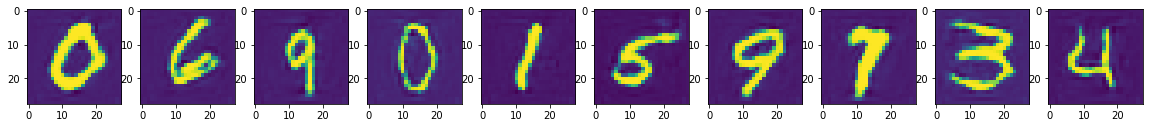

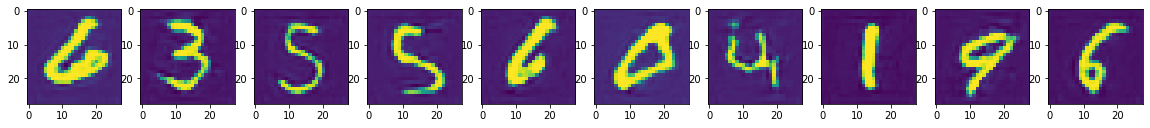

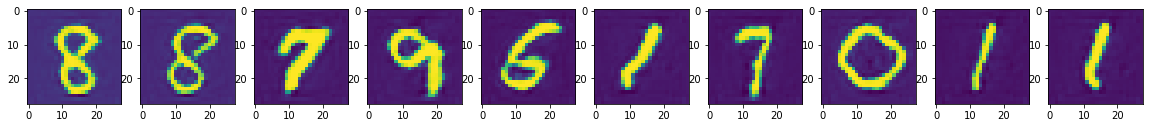

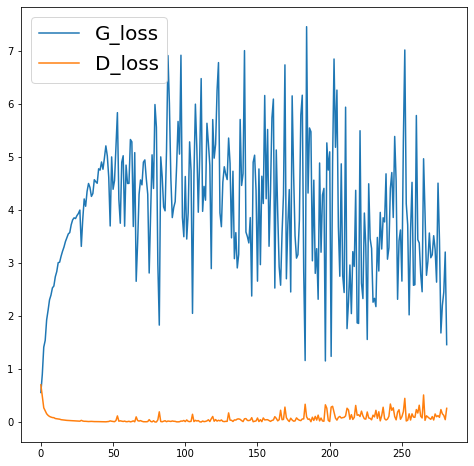

In [31]:

with torch.no_grad():
    # sample 1
    z = torch.randn(10, latent_dim)
    label = test_label[10:20].type(torch.FloatTensor)
    test_label_emb = positional_encoding_no_seq(ori_pos = (label.reshape(len(label), 1)).data.numpy(), 
                                                    emb_len = 32, d_model = 512)
    if device:
        z = z.to(device)
        label = label.to(device)
        test_label_emb = torch.from_numpy(test_label_emb).type(torch.FloatTensor).to(device)
    
    print(label[:10])
    fake_data = cG_p4(z, test_label_emb)
    print(fake_data.size())
    plt.figure(figsize=(20,4))
    for i in range(10):
        ax = plt.subplot(1, 10, i+1)
        plt.imshow(fake_data.data.cpu().numpy()[i,:,:])
    # sample 2
    z = torch.randn(10, latent_dim)
    label = test_label[50:60].type(torch.FloatTensor)
    test_label_emb = positional_encoding_no_seq(ori_pos = (label.reshape(len(label), 1)).data.numpy(), 
                                                    emb_len = 32, d_model = 512)
    if device:
        z = z.to(device)
        label = label.to(device)
        test_label_emb = torch.from_numpy(test_label_emb).type(torch.FloatTensor).to(device)
    print(label[:10])
    fake_data = cG_p4(z, test_label_emb)

    plt.figure(figsize=(20,4))
    for i in range(10):
        ax = plt.subplot(1, 10, i+1)
        plt.imshow(fake_data.data.cpu().numpy()[i,:,:])
    # sample 3 use fake label
    
    z = torch.randn(10, latent_dim)
    fake_label = torch.from_numpy(np.random.randint(0, 10, (10, 1))).type(torch.FloatTensor) # create fake label 
    print(fake_label.squeeze())
    test_label_emb = positional_encoding_no_seq(ori_pos = (fake_label).data.numpy(), 
                                                    emb_len = 32, d_model = 512)
    if device:
        z = z.to(device)
        test_label_emb = torch.from_numpy(test_label_emb).type(torch.FloatTensor).to(device)
    fake_data = cG_p4(z, test_label_emb)

    plt.figure(figsize=(20,4))
    for i in range(10):
        ax = plt.subplot(1, 10, i+1)
        plt.imshow(fake_data.data.cpu().numpy()[i,:,:])
    
    # get loss plot
    plt.figure(figsize =(8 ,8))
    plt.plot(np.arange(0, len(G_loss_log)), G_loss_log, label='G_loss')
    plt.plot(np.arange(0, len(D_loss_log)), D_loss_log, label='D_loss')
    plt.legend(fontsize=20)

In [3]:
'''
attention module with gan
Ref:
    [1]Building your own Self-attention GANs:
    https://towardsdatascience.com/building-your-own-self-attention-gans-e8c9b9fe8e51
    [2]
    https://github.com/franknb/Self-attention-DCGAN
    
not use SpectralNorm
'''

# ---------------------------------------
class cGan_atten(nn.Module):
    def __init__(self, in_dim, Ch_Divid ):
        super(cGan_atten, self).__init__()
        '''
        input shape = [BS, C, H, W]
        N = H*W
        
        in_Q = BS, C, N
        in_K = BS, C, N
        in_v = BS, C, N
        
        dot product:
        in_Q.transpose(-1,-2) dot in_K 
        atten_scores_map = BS, N, N
        atten_scores_map dot in_V   ==> [BS, C, N] o [BS, N, N] > [BS, C, N]
        #-------------------------------------------------------------------------------
        V dot scores or scores dot V???
        on score_map [BS, N(p1) , N(p2)]:
        value[BS, C, N]:            scores:                  N                                 value[BS, N, C]: 
                   N                                     Row --->                                        C
                                                column softmax (dim= 2 (-1) ) --->                       |
                                                  |       |                                              |
        C  ---->                            N     |    (dim = 1)                               N         v
                                                  |       |
                                                  v       v
        #-------------------------------------
        so, I think if V dot scores should be softmax(dim =  1)    
                       scores dot V           softmax(dim = -1)
        because for every single C(feature map) data
        
        at Ref[1] use softmax_layer(dim=-1) and V dot scores_map , BUT it has 'transpose with scores_map'
        *** if it is wrong , please give me command ,thx
        '''
        self.in_dim = in_dim
        self.divided = Ch_Divid
        
        self.W_k = nn.Conv2d(self.in_dim, self.in_dim//self.divided, kernel_size = 1, stride = 1)
        self.W_k_bn = nn.BatchNorm2d(self.in_dim//self.divided)
        self.W_q = nn.Conv2d(self.in_dim, self.in_dim//self.divided, kernel_size = 1, stride = 1)
        self.W_q_bn = nn.BatchNorm2d(self.in_dim//self.divided)
        self.W_v = nn.Conv2d(self.in_dim, self.in_dim, kernel_size = 1, stride = 1)
        self.W_v_bn = nn.BatchNorm2d(self.in_dim)
        
        self.softmax_layer = nn.Softmax(dim = -1)
    def forward(self, data):
        
        x = data
        BS, C, H, W = x.size()

        Query = nn.LeakyReLU(0.2)(self.W_q_bn(self.W_q(x))).view(BS, C//self.divided, H*W).transpose(-1,-2)
        Key = nn.LeakyReLU(0.2)(self.W_k_bn(self.W_k(x))).view(BS, C//self.divided, H*W)
        Value = nn.LeakyReLU(0.2)(self.W_v_bn(self.W_v(x))).view(BS, C, H*W).transpose(-1,-2)
        
        atten_map = torch.matmul(Query, Key) # 
        atten_map = self.softmax_layer(atten_map)
        context = torch.matmul(atten_map, Value).transpose(-1,-2).reshape(BS, C, H, W)
        
        out = context + data
        
        return out

if __name__ == '__main__':
    data = torch.rand(8, 64, 10, 10)
    model = cGan_atten(in_dim = 64, Ch_Divid = 8)
    print('atten out shape :', model(data).size())
        
class cDis_p5(nn.Module):
    def __init__(self, atten_block = cGan_atten):
        super(cDis_p5, self).__init__()
        # img
        self.conv_1 = nn.Conv2d(1, 32, kernel_size = 7, stride = 1) # [22, 22]
        self.conv_1_bn = nn.BatchNorm2d(32)
        self.conv_2 = nn.Conv2d(32, 64, kernel_size = 7, stride = 1) # [16, 16]
        self.conv_2_bn = nn.BatchNorm2d(64)
        self.conv_2_PReLu = nn.PReLU()
        
#         self.atten = nn.ModuleList([atten_block(in_dim = 128, Ch_Divid = 8) for _ in range(1)])
        
        self.conv_3 = nn.Conv2d(64+16, 128, kernel_size = 7, stride = 1) # [10, 10]
        self.conv_3_bn = nn.BatchNorm2d(128)

        # label
        self.deconv_label_1 = nn.ConvTranspose2d(32, 16, kernel_size = 16, stride = 1)
        self.deconv_label_1_bn = nn.BatchNorm2d(16)

        self.globel_pool_layer = nn.AdaptiveMaxPool2d(1)
        
        self.fc_1 = nn.Linear(128, 32)
        self.fc_2 = nn.Linear(32, 1)
    def forward(self, data, label):
        bs, H, W = data.size()
        x = data.view(bs, 1, H, W)
        
        x = nn.LeakyReLU(0.2)(self.conv_1_bn (self.conv_1(x)))
        x = nn.LeakyReLU(0.2)(self.conv_2_bn (self.conv_2(x)))
        
        y = label.view(bs, 32, 1, 1)
        y = nn.LeakyReLU(0.2)(self.deconv_label_1_bn(self.deconv_label_1(y)))
        
        cat_data = torch.cat([x, y], dim=1)
        feature =  nn.LeakyReLU(0.2)(self.conv_3_bn (self.conv_3(cat_data)))
#         for atten_layer in self.atten:
#             feature = atten_layer(feature)
        feature =  self.globel_pool_layer(feature).squeeze()

        pred_out = torch.sigmoid(self.fc_1(feature))
        pred_out = torch.sigmoid(self.fc_2(pred_out)).squeeze()

        return pred_out
    
class cGen_p5(nn.Module):
    def __init__(self, noise_dim, label_dim, divided_num, atten_block = cGan_atten):
        super(cGen_p5, self).__init__()
        self.noise_dim = noise_dim
        self.label_dim = label_dim
        self.divided_num = divided_num
        
        
        self.deconv_1 = nn.ConvTranspose2d(self.noise_dim+self.label_dim, 64, kernel_size = 10, stride = 1)
        self.deconv_1_bn = nn.BatchNorm2d(64)
        
        self.deconv_2 = nn.ConvTranspose2d(64, 32, kernel_size = 7, stride = 1)
        self.deconv_2_bn = nn.BatchNorm2d(32)
        
        self.deconv_3 = nn.ConvTranspose2d(32, 16, kernel_size = 5, stride = 1)
        self.deconv_3_bn = nn.BatchNorm2d(16)
        
        self.deconv_4 = nn.ConvTranspose2d(16, 8, kernel_size = 5, stride = 1)
        self.deconv_4_bn = nn.BatchNorm2d(8)
        
        self.atten = nn.ModuleList([atten_block(in_dim = 8, Ch_Divid = self.divided_num) for _ in range(1)])
        
        self.deconv_5 = nn.ConvTranspose2d(8, 1, kernel_size = 5, stride = 1)
        self.deconv_5_bn = nn.BatchNorm2d(1)
        
    def forward(self, noise_z, label):
        bs, C = noise_z.size()
        x = noise_z
#         y = nn.Softmax(dim=-1)(label) 
        y = torch.relu(label)
        
        data = torch.cat([x, y], dim=1)
        
        data = data.view(bs, 132, 1, 1)
        
        feature = nn.LeakyReLU(0.2)(self.deconv_1_bn(self.deconv_1(data)))
        feature = nn.LeakyReLU(0.2)(self.deconv_2_bn(self.deconv_2(feature)))
        feature = nn.LeakyReLU(0.2)(self.deconv_3_bn(self.deconv_3(feature)))
        feature = nn.LeakyReLU(0.2)(self.deconv_4_bn(self.deconv_4(feature)))
        for atten_layer in self.atten:
            feature = atten_layer(feature)
        feature = nn.LeakyReLU(0.2)(self.deconv_5_bn(self.deconv_5(feature)))

        fake_data = torch.tanh(feature.squeeze())
        
        return fake_data 
if __name__ == '__main__':
    img_data = torch.rand(16, 28, 28)
    label = torch.rand(16, 1)
    real_label_emb = positional_encoding_no_seq(ori_pos = label.data.numpy(), emb_len = 32, d_model = 512)
    real_label_emb = torch.from_numpy(real_label_emb).type(torch.FloatTensor)
    print(real_label_emb.size())
    # D
    Dis_model = cDis_p5()
    Dis_model(img_data, real_label_emb)
    # G
    Gen_model = cGen_p5(noise_dim = 100, label_dim = 32, divided_num = 8 )
    z = torch.rand(16,100)
    Gen_model(z, real_label_emb)

atten out shape : torch.Size([8, 64, 10, 10])
torch.Size([16, 32])


In [30]:
EPOCH = 30
BATCH_SIZE = 64
latent_dim = 100

bce_loss = nn.BCELoss()
cD_p5 = cDis_p5()
cG_p5 = cGen_p5(noise_dim = latent_dim, label_dim = 32, divided_num = 8 )

if torch.cuda.is_available():
    bce_loss.cuda()
    cD_p5.cuda()
    cG_p5.cuda()
optim_cD_p5 = torch.optim.Adam(cD_p5.parameters(), lr = 0.0001)
optim_cG_p5 = torch.optim.Adam(cG_p5.parameters(), lr = 0.0001)

train_data_dataset = torch.utils.data.TensorDataset(train_data, train_label)
train_dataloader = torch.utils.data.DataLoader(dataset = train_data_dataset, batch_size = BATCH_SIZE, shuffle=True)

G_loss_log = []
D_loss_log = []
log_index = 0
'''
*** fail train loss with C//8***
Training gan part 
'''
for epoch in range(EPOCH):
    for n, (data, label) in enumerate(train_dataloader):
        real_valid = torch.ones(data.size(0))
        fake_valid = torch.zeros(data.size(0))
        z = torch.randn(data.size(0), latent_dim)
        real_data = data
        real_label = label
        
        # get emb   [bs, 1] >> [bs, emb_len]
        real_label_emb = positional_encoding_no_seq(ori_pos = (real_label.reshape(len(real_label), 1)).data.numpy(), 
                                                    emb_len = 32, d_model = 512) 
        
        real_label_emb = torch.from_numpy(real_label_emb).type(torch.FloatTensor)
        
        if torch.cuda.is_available():
            real_valid = real_valid.cuda()
            fake_valid = fake_valid.cuda()
            z = z.cuda()
            real_data = real_data.cuda()
            real_label = real_label.cuda()
            real_label_emb = real_label_emb.cuda()
            
        # === train gen ===
        optim_cG_p5.zero_grad()
        fake_data  = cG_p5(z, real_label_emb) # use real label
        
        cG_loss = bce_loss( cD_p5(fake_data, real_label_emb), real_valid) # judge fake img is real
        cG_loss.backward()
        optim_cG_p5.step()

        # === train dis ===
        optim_cD_p5.zero_grad()
        real_loss = bce_loss(cD_p5(real_data, real_label_emb),          real_valid) # judge real img is real
        fake_loss = bce_loss(cD_p5(fake_data.detach(), real_label_emb), fake_valid)
        
        cD_loss = (real_loss+fake_loss)/2
        cD_loss.backward()
        optim_cD_p5.step()
        if log_index % 100 == 0:
            G_loss_log.append(cG_loss)
            D_loss_log.append(cD_loss)
        log_index += 1
    with torch.no_grad():
        print('Epoch[{}] >> cG_loss : {:.4f}, cD_loss : {:.4f}'.format(epoch+1, cG_loss.item(), cD_loss.item()))

Epoch[1] >> cG_loss : 2.5217, cD_loss : 0.0739
Epoch[2] >> cG_loss : 3.1180, cD_loss : 0.0362
Epoch[3] >> cG_loss : 3.8849, cD_loss : 0.0174
Epoch[4] >> cG_loss : 4.3054, cD_loss : 0.0259
Epoch[5] >> cG_loss : 4.8579, cD_loss : 0.0075
Epoch[6] >> cG_loss : 5.3222, cD_loss : 0.0063
Epoch[7] >> cG_loss : 3.9576, cD_loss : 0.0291
Epoch[8] >> cG_loss : 4.4612, cD_loss : 0.0091
Epoch[9] >> cG_loss : 6.4908, cD_loss : 0.0031
Epoch[10] >> cG_loss : 5.6796, cD_loss : 0.0036
Epoch[11] >> cG_loss : 6.7224, cD_loss : 0.0024
Epoch[12] >> cG_loss : 5.3589, cD_loss : 0.0064
Epoch[13] >> cG_loss : 4.6078, cD_loss : 0.0212
Epoch[14] >> cG_loss : 6.9370, cD_loss : 0.0022
Epoch[15] >> cG_loss : 6.3320, cD_loss : 0.0016
Epoch[16] >> cG_loss : 4.7148, cD_loss : 0.0146
Epoch[17] >> cG_loss : 7.0075, cD_loss : 0.0028
Epoch[18] >> cG_loss : 7.1228, cD_loss : 0.0008
Epoch[19] >> cG_loss : 7.5036, cD_loss : 0.0006
Epoch[20] >> cG_loss : 5.6890, cD_loss : 0.0026
Epoch[21] >> cG_loss : 5.5327, cD_loss : 0.0039
E

tensor([0., 6., 9., 0., 1., 5., 9., 7., 3., 4.], device='cuda:0')
torch.Size([10, 28, 28])


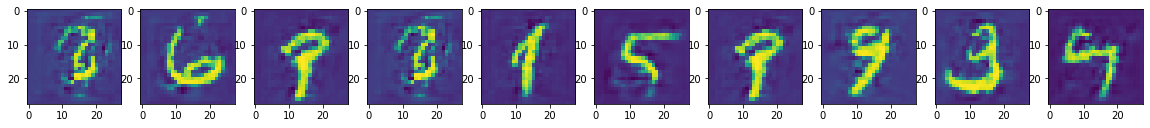

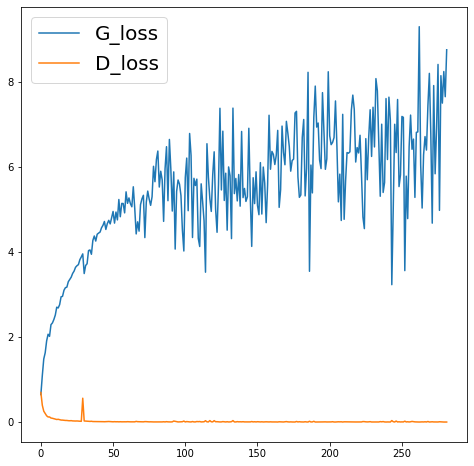

In [31]:
'''
with C//8 fail
'''
with torch.no_grad():
    # sample 1
    z = torch.randn(10, latent_dim)
    label = test_label[10:20].type(torch.FloatTensor)
    test_label_emb = positional_encoding_no_seq(ori_pos = (label.reshape(len(label), 1)).data.numpy(), 
                                                    emb_len = 32, d_model = 512)
    if device:
        z = z.to(device)
        label = label.to(device)
        test_label_emb = torch.from_numpy(test_label_emb).type(torch.FloatTensor).to(device)
    
    print(label[:10])
    fake_data = cG_p5(z, test_label_emb)
    print(fake_data.size())
    plt.figure(figsize=(20,4))
    for i in range(10):
        ax = plt.subplot(1, 10, i+1)
        plt.imshow(fake_data.data.cpu().numpy()[i,:,:])
    # get loss plot
    plt.figure(figsize =(8 ,8))
    plt.plot(np.arange(0, len(G_loss_log)), G_loss_log, label='G_loss')
    plt.plot(np.arange(0, len(D_loss_log)), D_loss_log, label='D_loss')
    plt.legend(fontsize=20)

In [32]:
EPOCH = 30
BATCH_SIZE = 64
latent_dim = 100

bce_loss = nn.BCELoss()
cD_p5 = cDis_p5()
cG_p5 = cGen_p5(noise_dim = latent_dim, label_dim = 32, divided_num = 8 )

if torch.cuda.is_available():
    bce_loss.cuda()
    cD_p5.cuda()
    cG_p5.cuda()
optim_cD_p5 = torch.optim.Adam(cD_p5.parameters(), lr = 0.0001)
optim_cG_p5 = torch.optim.Adam(cG_p5.parameters(), lr = 0.0001)

train_data_dataset = torch.utils.data.TensorDataset(train_data, train_label)
train_dataloader = torch.utils.data.DataLoader(dataset = train_data_dataset, batch_size = BATCH_SIZE, shuffle=True)

G_loss_log = []
D_loss_log = []
log_index = 0
'''
*** successful train loss with C//8***
Training gan part
'''
for epoch in range(EPOCH):
    for n, (data, label) in enumerate(train_dataloader):
        real_valid = torch.ones(data.size(0))
        fake_valid = torch.zeros(data.size(0))
        z = torch.randn(data.size(0), latent_dim)
        real_data = data
        real_label = label
        
        # get emb   [bs, 1] >> [bs, emb_len]
        real_label_emb = positional_encoding_no_seq(ori_pos = (real_label.reshape(len(real_label), 1)).data.numpy(), 
                                                    emb_len = 32, d_model = 512) 
        
        real_label_emb = torch.from_numpy(real_label_emb).type(torch.FloatTensor)
        
        if torch.cuda.is_available():
            real_valid = real_valid.cuda()
            fake_valid = fake_valid.cuda()
            z = z.cuda()
            real_data = real_data.cuda()
            real_label = real_label.cuda()
            real_label_emb = real_label_emb.cuda()
            
        # === train gen ===
        optim_cG_p5.zero_grad()
        fake_data  = cG_p5(z, real_label_emb) # use real label
        
        cG_loss = bce_loss( cD_p5(fake_data, real_label_emb), real_valid) # judge fake img is real
        cG_loss.backward()
        optim_cG_p5.step()

        # === train dis ===
        optim_cD_p5.zero_grad()
        real_loss = bce_loss(cD_p5(real_data, real_label_emb),          real_valid) # judge real img is real
        fake_loss = bce_loss(cD_p5(fake_data.detach(), real_label_emb), fake_valid)
        
        cD_loss = (real_loss+fake_loss)/2
        cD_loss.backward()
        optim_cD_p5.step()
        if log_index % 100 == 0:
            G_loss_log.append(cG_loss)
            D_loss_log.append(cD_loss)
        log_index += 1
    with torch.no_grad():
        print('Epoch[{}] >> cG_loss : {:.4f}, cD_loss : {:.4f}'.format(epoch+1, cG_loss.item(), cD_loss.item()))

Epoch[1] >> cG_loss : 2.9768, cD_loss : 0.0870
Epoch[2] >> cG_loss : 3.5610, cD_loss : 0.0458
Epoch[3] >> cG_loss : 4.1417, cD_loss : 0.0279
Epoch[4] >> cG_loss : 4.2504, cD_loss : 0.0249
Epoch[5] >> cG_loss : 2.6636, cD_loss : 0.0907
Epoch[6] >> cG_loss : 5.0192, cD_loss : 0.0712
Epoch[7] >> cG_loss : 3.3898, cD_loss : 0.0463
Epoch[8] >> cG_loss : 4.2468, cD_loss : 0.0398
Epoch[9] >> cG_loss : 3.5151, cD_loss : 0.0357
Epoch[10] >> cG_loss : 1.4701, cD_loss : 0.3356
Epoch[11] >> cG_loss : 3.9317, cD_loss : 0.5220
Epoch[12] >> cG_loss : 2.3853, cD_loss : 0.2029
Epoch[13] >> cG_loss : 5.8809, cD_loss : 0.2891
Epoch[14] >> cG_loss : 3.1186, cD_loss : 0.3612
Epoch[15] >> cG_loss : 2.1291, cD_loss : 0.3754
Epoch[16] >> cG_loss : 2.6629, cD_loss : 0.3379
Epoch[17] >> cG_loss : 2.6672, cD_loss : 0.1366
Epoch[18] >> cG_loss : 0.6435, cD_loss : 0.5553
Epoch[19] >> cG_loss : 1.0497, cD_loss : 0.3960
Epoch[20] >> cG_loss : 2.0239, cD_loss : 0.1204
Epoch[21] >> cG_loss : 2.0918, cD_loss : 0.1089
E

tensor([0., 6., 9., 0., 1., 5., 9., 7., 3., 4.], device='cuda:0')
torch.Size([10, 28, 28])


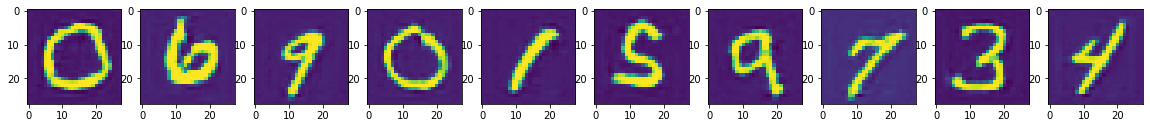

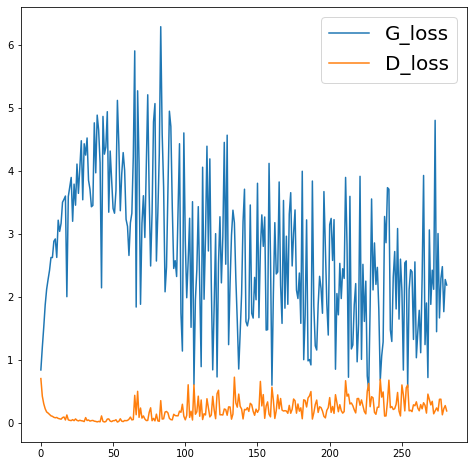

In [33]:
'''
with C//8 fail successful
'''
with torch.no_grad():
    # sample 1
    z = torch.randn(10, latent_dim)
    label = test_label[10:20].type(torch.FloatTensor)
    test_label_emb = positional_encoding_no_seq(ori_pos = (label.reshape(len(label), 1)).data.numpy(), 
                                                    emb_len = 32, d_model = 512)
    if device:
        z = z.to(device)
        label = label.to(device)
        test_label_emb = torch.from_numpy(test_label_emb).type(torch.FloatTensor).to(device)
    
    print(label[:10])
    fake_data = cG_p5(z, test_label_emb)
    print(fake_data.size())
    plt.figure(figsize=(20,4))
    for i in range(10):
        ax = plt.subplot(1, 10, i+1)
        plt.imshow(fake_data.data.cpu().numpy()[i,:,:])
    # get loss plot
    plt.figure(figsize =(8 ,8))
    plt.plot(np.arange(0, len(G_loss_log)), G_loss_log, label='G_loss')
    plt.plot(np.arange(0, len(D_loss_log)), D_loss_log, label='D_loss')
    plt.legend(fontsize=20)

In [ ]:
'''
sampling for C//2, C//4, C//8 with (p.5)
'''

tensor([0., 6., 9., 0., 1., 5., 9., 7., 3., 4.], device='cuda:0')
torch.Size([10, 28, 28])
tensor([6., 3., 5., 5., 6., 0., 4., 1., 9., 5.], device='cuda:0')
tensor([5., 5., 0., 4., 9., 1., 5., 2., 3., 4.])


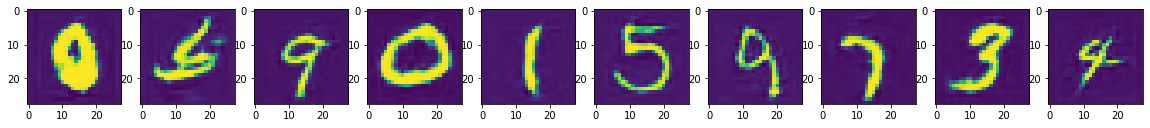

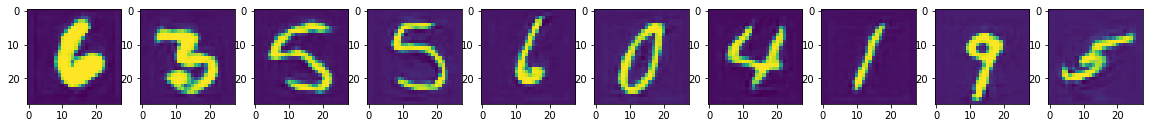

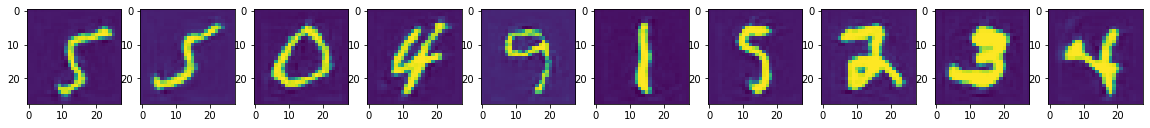

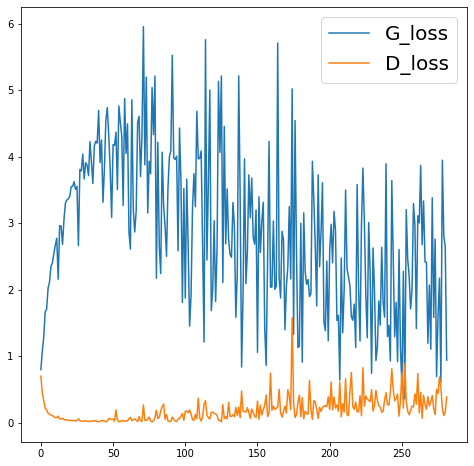

In [77]:
'''
with C//2
'''
with torch.no_grad():
    # sample 1
    z = torch.randn(10, latent_dim)
    label = test_label[10:20].type(torch.FloatTensor)
    test_label_emb = positional_encoding_no_seq(ori_pos = (label.reshape(len(label), 1)).data.numpy(), 
                                                    emb_len = 32, d_model = 512)
    if device:
        z = z.to(device)
        label = label.to(device)
        test_label_emb = torch.from_numpy(test_label_emb).type(torch.FloatTensor).to(device)
    
    print(label[:10])
    fake_data = cG_p5(z, test_label_emb)
    print(fake_data.size())
    plt.figure(figsize=(20,4))
    for i in range(10):
        ax = plt.subplot(1, 10, i+1)
        plt.imshow(fake_data.data.cpu().numpy()[i,:,:])
    # sample 2
    z = torch.randn(10, latent_dim)
    label = test_label[50:60].type(torch.FloatTensor)
    test_label_emb = positional_encoding_no_seq(ori_pos = (label.reshape(len(label), 1)).data.numpy(), 
                                                    emb_len = 32, d_model = 512)
    if device:
        z = z.to(device)
        label = label.to(device)
        test_label_emb = torch.from_numpy(test_label_emb).type(torch.FloatTensor).to(device)
    print(label[:10])
    fake_data = cG_p5(z, test_label_emb)

    plt.figure(figsize=(20,4))
    for i in range(10):
        ax = plt.subplot(1, 10, i+1)
        plt.imshow(fake_data.data.cpu().numpy()[i,:,:])
    # sample 3 use fake label
    
    z = torch.randn(10, latent_dim)
    fake_label = torch.from_numpy(np.random.randint(0, 10, (10, 1))).type(torch.FloatTensor) # create fake label 
    print(fake_label.squeeze())
    test_label_emb = positional_encoding_no_seq(ori_pos = (fake_label).data.numpy(), 
                                                    emb_len = 32, d_model = 512)
    if device:
        z = z.to(device)
        test_label_emb = torch.from_numpy(test_label_emb).type(torch.FloatTensor).to(device)
    fake_data = cG_p5(z, test_label_emb)

    plt.figure(figsize=(20,4))
    for i in range(10):
        ax = plt.subplot(1, 10, i+1)
        plt.imshow(fake_data.data.cpu().numpy()[i,:,:])
    
    # get loss plot
    plt.figure(figsize =(8 ,8))
    plt.plot(np.arange(0, len(G_loss_log)), G_loss_log, label='G_loss')
    plt.plot(np.arange(0, len(D_loss_log)), D_loss_log, label='D_loss')
    plt.legend(fontsize=20)

tensor([0., 6., 9., 0., 1., 5., 9., 7., 3., 4.], device='cuda:0')
torch.Size([10, 28, 28])
tensor([6., 3., 5., 5., 6., 0., 4., 1., 9., 5.], device='cuda:0')
tensor([3., 3., 9., 1., 0., 6., 3., 6., 0., 4.])


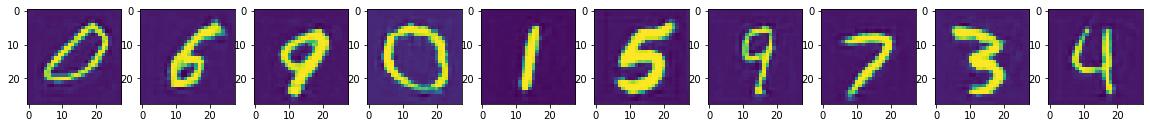

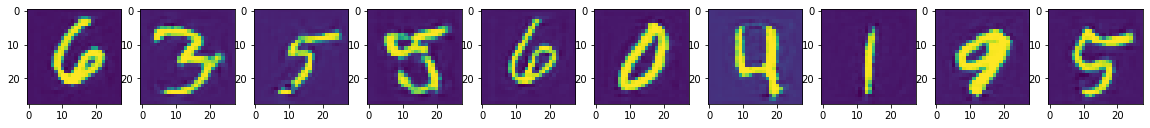

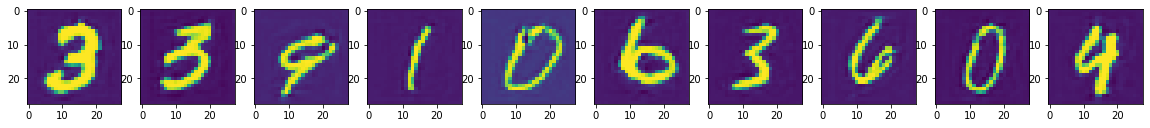

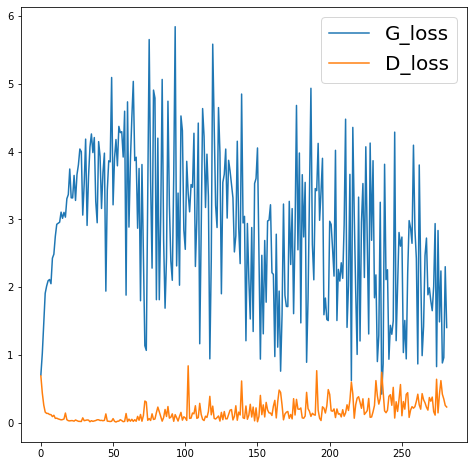

In [81]:
'''
with C//4
'''
with torch.no_grad():
    # sample 1
    z = torch.randn(10, latent_dim)
    label = test_label[10:20].type(torch.FloatTensor)
    test_label_emb = positional_encoding_no_seq(ori_pos = (label.reshape(len(label), 1)).data.numpy(), 
                                                    emb_len = 32, d_model = 512)
    if device:
        z = z.to(device)
        label = label.to(device)
        test_label_emb = torch.from_numpy(test_label_emb).type(torch.FloatTensor).to(device)
    
    print(label[:10])
    fake_data = cG_p5(z, test_label_emb)
    print(fake_data.size())
    plt.figure(figsize=(20,4))
    for i in range(10):
        ax = plt.subplot(1, 10, i+1)
        plt.imshow(fake_data.data.cpu().numpy()[i,:,:])
    # sample 2
    z = torch.randn(10, latent_dim)
    label = test_label[50:60].type(torch.FloatTensor)
    test_label_emb = positional_encoding_no_seq(ori_pos = (label.reshape(len(label), 1)).data.numpy(), 
                                                    emb_len = 32, d_model = 512)
    if device:
        z = z.to(device)
        label = label.to(device)
        test_label_emb = torch.from_numpy(test_label_emb).type(torch.FloatTensor).to(device)
    print(label[:10])
    fake_data = cG_p5(z, test_label_emb)

    plt.figure(figsize=(20,4))
    for i in range(10):
        ax = plt.subplot(1, 10, i+1)
        plt.imshow(fake_data.data.cpu().numpy()[i,:,:])
    # sample 3 use fake label
    
    z = torch.randn(10, latent_dim)
    fake_label = torch.from_numpy(np.random.randint(0, 10, (10, 1))).type(torch.FloatTensor) # create fake label 
    print(fake_label.squeeze())
    test_label_emb = positional_encoding_no_seq(ori_pos = (fake_label).data.numpy(), 
                                                    emb_len = 32, d_model = 512)
    if device:
        z = z.to(device)
        test_label_emb = torch.from_numpy(test_label_emb).type(torch.FloatTensor).to(device)
    fake_data = cG_p5(z, test_label_emb)

    plt.figure(figsize=(20,4))
    for i in range(10):
        ax = plt.subplot(1, 10, i+1)
        plt.imshow(fake_data.data.cpu().numpy()[i,:,:])
    
    # get loss plot
    plt.figure(figsize =(8 ,8))
    plt.plot(np.arange(0, len(G_loss_log)), G_loss_log, label='G_loss')
    plt.plot(np.arange(0, len(D_loss_log)), D_loss_log, label='D_loss')
    plt.legend(fontsize=20)

tensor([0., 6., 9., 0., 1., 5., 9., 7., 3., 4.], device='cuda:0')
torch.Size([10, 28, 28])
tensor([6., 3., 5., 5., 6., 0., 4., 1., 9., 5.], device='cuda:0')
tensor([3., 0., 3., 1., 6., 3., 1., 5., 2., 4.])


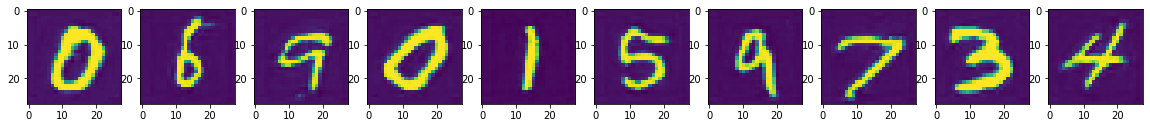

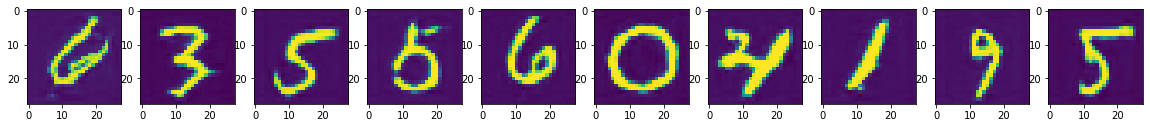

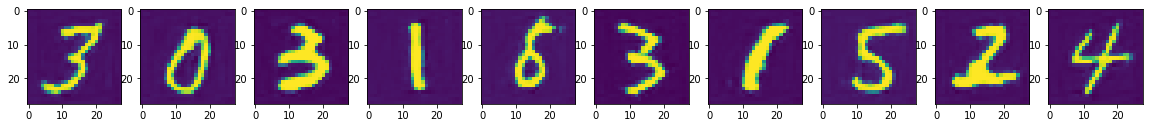

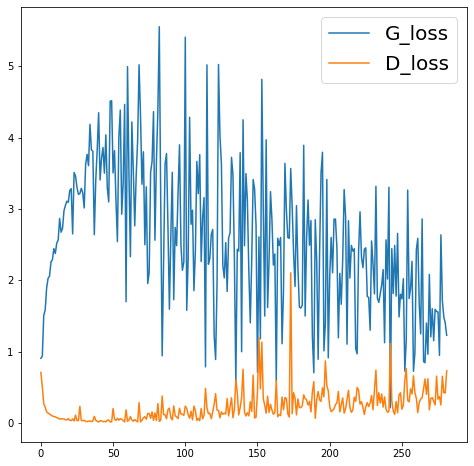

In [106]:
'''
with C//8
'''
with torch.no_grad():
    # sample 1
    z = torch.randn(10, latent_dim)
    label = test_label[10:20].type(torch.FloatTensor)
    test_label_emb = positional_encoding_no_seq(ori_pos = (label.reshape(len(label), 1)).data.numpy(), 
                                                    emb_len = 32, d_model = 512)
    if device:
        z = z.to(device)
        label = label.to(device)
        test_label_emb = torch.from_numpy(test_label_emb).type(torch.FloatTensor).to(device)
    
    print(label[:10])
    fake_data = cG_p5(z, test_label_emb)
    print(fake_data.size())
    plt.figure(figsize=(20,4))
    for i in range(10):
        ax = plt.subplot(1, 10, i+1)
        plt.imshow(fake_data.data.cpu().numpy()[i,:,:])
    # sample 2
    z = torch.randn(10, latent_dim)
    label = test_label[50:60].type(torch.FloatTensor)
    test_label_emb = positional_encoding_no_seq(ori_pos = (label.reshape(len(label), 1)).data.numpy(), 
                                                    emb_len = 32, d_model = 512)
    if device:
        z = z.to(device)
        label = label.to(device)
        test_label_emb = torch.from_numpy(test_label_emb).type(torch.FloatTensor).to(device)
    print(label[:10])
    fake_data = cG_p5(z, test_label_emb)

    plt.figure(figsize=(20,4))
    for i in range(10):
        ax = plt.subplot(1, 10, i+1)
        plt.imshow(fake_data.data.cpu().numpy()[i,:,:])
    # sample 3 use fake label
    
    z = torch.randn(10, latent_dim)
    fake_label = torch.from_numpy(np.random.randint(0, 10, (10, 1))).type(torch.FloatTensor) # create fake label 
    print(fake_label.squeeze())
    test_label_emb = positional_encoding_no_seq(ori_pos = (fake_label).data.numpy(), 
                                                    emb_len = 32, d_model = 512)
    if device:
        z = z.to(device)
        test_label_emb = torch.from_numpy(test_label_emb).type(torch.FloatTensor).to(device)
    fake_data = cG_p5(z, test_label_emb)

    plt.figure(figsize=(20,4))
    for i in range(10):
        ax = plt.subplot(1, 10, i+1)
        plt.imshow(fake_data.data.cpu().numpy()[i,:,:])
    
    # get loss plot
    plt.figure(figsize =(8 ,8))
    plt.plot(np.arange(0, len(G_loss_log)), G_loss_log, label='G_loss')
    plt.plot(np.arange(0, len(D_loss_log)), D_loss_log, label='D_loss')
    plt.legend(fontsize=20)

In [4]:
'''
part5-5
main test is 'Attention Label' matrix
and then
get atten label to concate noise_z feature or mul
'''

class cGen_p5_AZL(nn.Module):
    def __init__(self, noise_dim, label_dim, divided_num, atten_block = cGan_atten):
        super(cGen_p5_AZL, self).__init__()
        self.noise_dim = noise_dim
        self.label_dim = label_dim
        self.divided_num = divided_num
        
        # noise_z  ----------------------------------------
        self.deconv_1 = nn.ConvTranspose2d(self.noise_dim, 64, kernel_size = 10, stride = 1)
        self.deconv_1_bn = nn.BatchNorm2d(64)
        # label ----------------------------------------
        self.deconv_label = nn.ConvTranspose2d(self.label_dim, 16, kernel_size = 10, stride = 1)
        self.deconv_label_bn = nn.BatchNorm2d(16)
        
        self.deconv_label_1x1 = nn.ConvTranspose2d(16, 8, kernel_size = 1, stride = 1)
        self.deconv_label_1x1_bn = nn.BatchNorm2d(8)
        
        # cat ----------------------------------------
        self.deconv_2 = nn.ConvTranspose2d(64+8, 32, kernel_size = 7, stride = 1)
        self.deconv_2_bn = nn.BatchNorm2d(32)
        
        self.deconv_3 = nn.ConvTranspose2d(32, 16, kernel_size = 5, stride = 1)
        self.deconv_3_bn = nn.BatchNorm2d(16)
        
        self.deconv_4 = nn.ConvTranspose2d(16, 8, kernel_size = 5, stride = 1)
        self.deconv_4_bn = nn.BatchNorm2d(8)
        
        self.atten = nn.ModuleList([atten_block(in_dim = 8, Ch_Divid = self.divided_num) for _ in range(1)])
        
        self.deconv_5 = nn.ConvTranspose2d(8, 1, kernel_size = 5, stride = 1)
        self.deconv_5_bn = nn.BatchNorm2d(1)
        
    def forward(self, noise_z, label):
        bs, C = noise_z.size()
        x = noise_z
        x = x.view(bs, self.noise_dim, 1, 1)
        x = nn.LeakyReLU(0.2)(self.deconv_1_bn(self.deconv_1(x)))

        y = torch.relu(label).view(bs, self.label_dim, 1, 1)
        y = nn.LeakyReLU(0.2)(self.deconv_label_bn(self.deconv_label(y)))
        y = nn.LeakyReLU(0.2)(self.deconv_label_1x1_bn(self.deconv_label_1x1(y)))
        
        # cat 
        data = torch.cat([x, y], dim = 1)
        feature = nn.LeakyReLU(0.2)(self.deconv_2_bn(self.deconv_2(data)))
        feature = nn.LeakyReLU(0.2)(self.deconv_3_bn(self.deconv_3(feature)))
        feature = nn.LeakyReLU(0.2)(self.deconv_4_bn(self.deconv_4(feature)))
        for atten_layer in self.atten:
            feature = atten_layer(feature)
        feature = nn.LeakyReLU(0.2)(self.deconv_5_bn(self.deconv_5(feature)))

        fake_data = torch.tanh(feature.squeeze())
        
        return fake_data 
# ---------------------------------------

class cGen_p5_AL(nn.Module):
    def __init__(self, noise_dim, label_dim, divided_num ,atten_block = cGan_atten):
        super(cGen_p5_AL, self).__init__()
        self.noise_dim = noise_dim
        self.label_dim = label_dim
        self.divided_num = divided_num
        # noise_z  ----------------------------------------
        self.deconv_1 = nn.ConvTranspose2d(self.noise_dim, 64, kernel_size = 10, stride = 1)
        self.deconv_1_bn = nn.BatchNorm2d(64)
        # label ----------------------------------------
        self.deconv_label = nn.ConvTranspose2d(self.label_dim, 16, kernel_size = 10, stride = 1)
        self.deconv_label_bn = nn.BatchNorm2d(16)
        
        self.deconv_label_1x1 = nn.ConvTranspose2d(16, 8, kernel_size = 1, stride = 1)
        self.deconv_label_1x1_bn = nn.BatchNorm2d(8)
        
        self.atten = nn.ModuleList([atten_block(in_dim = 8, Ch_Divid = self.divided_num) for _ in range(1)])
        # cat ----------------------------------------
        self.deconv_2 = nn.ConvTranspose2d(64+8, 32, kernel_size = 7, stride = 1)
        self.deconv_2_bn = nn.BatchNorm2d(32)
        
        self.deconv_3 = nn.ConvTranspose2d(32, 16, kernel_size = 5, stride = 1)
        self.deconv_3_bn = nn.BatchNorm2d(16)
        
        self.deconv_4 = nn.ConvTranspose2d(16, 8, kernel_size = 5, stride = 1)
        self.deconv_4_bn = nn.BatchNorm2d(8)
        
        self.deconv_5 = nn.ConvTranspose2d(8, 1, kernel_size = 5, stride = 1)
        self.deconv_5_bn = nn.BatchNorm2d(1)
        
    def forward(self, noise_z, label):
        bs = noise_z.size(0)
        x = noise_z
        x = x.view(bs, self.noise_dim, 1, 1)
        x = nn.LeakyReLU(0.2)(self.deconv_1_bn(self.deconv_1(x)))

        y = torch.relu(label).view(bs, self.label_dim, 1, 1)
        y = nn.LeakyReLU(0.2)(self.deconv_label_bn(self.deconv_label(y)))
        y = nn.LeakyReLU(0.2)(self.deconv_label_1x1_bn(self.deconv_label_1x1(y)))
        for label_atten in self.atten:
            y = label_atten(y)
        # cat 
        data = torch.cat([x, y], dim = 1)
        feature = nn.LeakyReLU(0.2)(self.deconv_2_bn(self.deconv_2(data)))
        feature = nn.LeakyReLU(0.2)(self.deconv_3_bn(self.deconv_3(feature)))
        feature = nn.LeakyReLU(0.2)(self.deconv_4_bn(self.deconv_4(feature)))
        feature = nn.LeakyReLU(0.2)(self.deconv_5_bn(self.deconv_5(feature)))

        fake_data = torch.tanh(feature.squeeze())
        
        return fake_data 
if __name__ == '__main__':
    
    label = torch.rand(16, 1)
    real_label_emb = positional_encoding_no_seq(ori_pos = label.data.numpy(), emb_len = 32, d_model = 512)
    real_label_emb = torch.from_numpy(real_label_emb).type(torch.FloatTensor)

    model = cGen_p5_AL(noise_dim = 100, label_dim = 32, divided_num = 8 )
    z = torch.rand(16,100)
    print(model(z, real_label_emb).size()) # [BS, H, W]
    model = cGen_p5_AZL(noise_dim = 100, label_dim = 32, divided_num = 8 )
    print(model(z, real_label_emb).size()) # [BS, H, W]

torch.Size([16, 28, 28])
torch.Size([16, 28, 28])




Epoch[1] >> cG_loss : 1.8533, cD_loss : 0.1073
Epoch[1] >> cG_AL_loss : 1.5815, cD_AL_loss : 0.1673


Epoch[2] >> cG_loss : 2.4116, cD_loss : 0.0677
Epoch[2] >> cG_AL_loss : 2.7043, cD_AL_loss : 0.0586


Epoch[3] >> cG_loss : 2.4865, cD_loss : 0.0631
Epoch[3] >> cG_AL_loss : 3.5756, cD_AL_loss : 0.1463


Epoch[4] >> cG_loss : 2.9767, cD_loss : 0.1118
Epoch[4] >> cG_AL_loss : 3.3072, cD_AL_loss : 0.0296


Epoch[5] >> cG_loss : 3.7637, cD_loss : 0.0782
Epoch[5] >> cG_AL_loss : 3.0486, cD_AL_loss : 0.0429


Epoch[6] >> cG_loss : 3.4805, cD_loss : 0.0517
Epoch[6] >> cG_AL_loss : 4.6829, cD_AL_loss : 0.0139


Epoch[7] >> cG_loss : 2.8665, cD_loss : 0.0383
Epoch[7] >> cG_AL_loss : 4.2636, cD_AL_loss : 0.0615


Epoch[8] >> cG_loss : 3.9299, cD_loss : 0.0246
Epoch[8] >> cG_AL_loss : 4.0780, cD_AL_loss : 0.0127


Epoch[9] >> cG_loss : 3.2798, cD_loss : 0.0516
Epoch[9] >> cG_AL_loss : 3.0685, cD_AL_loss : 0.0455


Epoch[10] >> cG_loss : 1.3740, cD_loss : 0.1988
Epoch[10] >> cG_AL_loss : 0.8590

/home/nclab62159/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:116: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).




Epoch[22] >> cG_loss : 2.3874, cD_loss : 0.2667
Epoch[22] >> cG_AL_loss : 1.1007, cD_AL_loss : 0.4424


Epoch[23] >> cG_loss : 1.5469, cD_loss : 0.3626
Epoch[23] >> cG_AL_loss : 3.5951, cD_AL_loss : 0.0646


Epoch[24] >> cG_loss : 2.2063, cD_loss : 0.2244
Epoch[24] >> cG_AL_loss : 2.1725, cD_AL_loss : 0.0896


Epoch[25] >> cG_loss : 2.1137, cD_loss : 0.1313
Epoch[25] >> cG_AL_loss : 1.9730, cD_AL_loss : 0.1128


Epoch[26] >> cG_loss : 1.5389, cD_loss : 0.1856
Epoch[26] >> cG_AL_loss : 1.9374, cD_AL_loss : 0.1602


Epoch[27] >> cG_loss : 3.2116, cD_loss : 0.0515
Epoch[27] >> cG_AL_loss : 2.9724, cD_AL_loss : 0.0752


Epoch[28] >> cG_loss : 1.4772, cD_loss : 0.2013
Epoch[28] >> cG_AL_loss : 3.9890, cD_AL_loss : 0.0214


Epoch[29] >> cG_loss : 2.9457, cD_loss : 0.0981
Epoch[29] >> cG_AL_loss : 6.1185, cD_AL_loss : 1.0502


Epoch[30] >> cG_loss : 3.4278, cD_loss : 0.0430
Epoch[30] >> cG_AL_loss : 2.8203, cD_AL_loss : 0.0592
tensor([6., 5., 4., 0., 7., 4., 0., 1.])


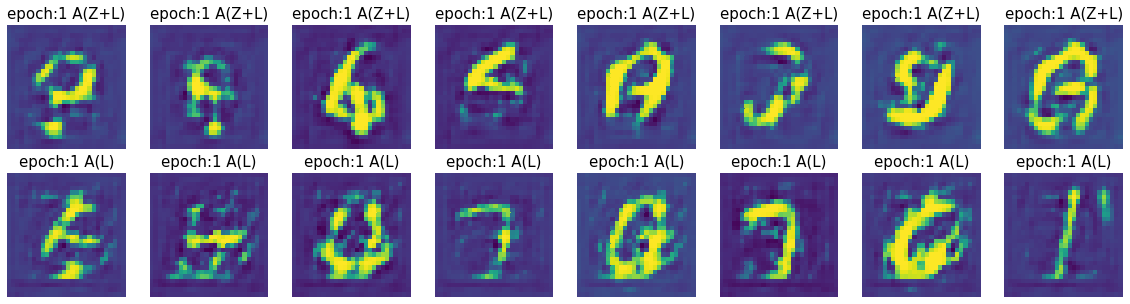

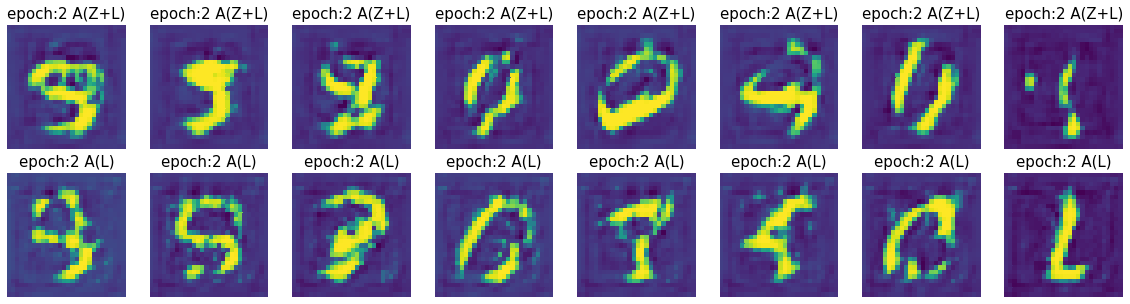

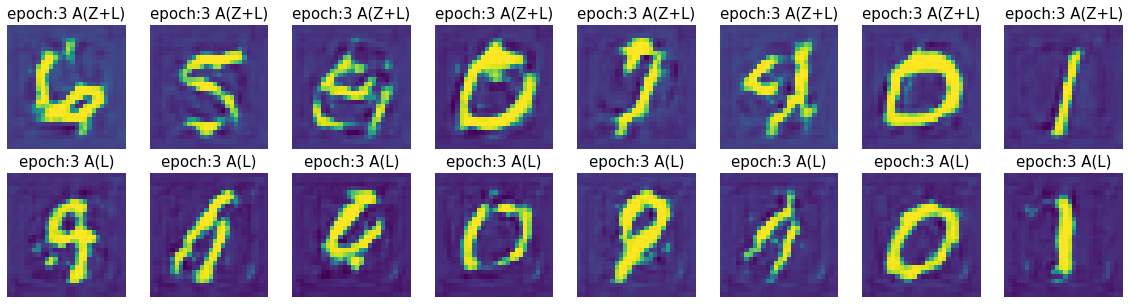

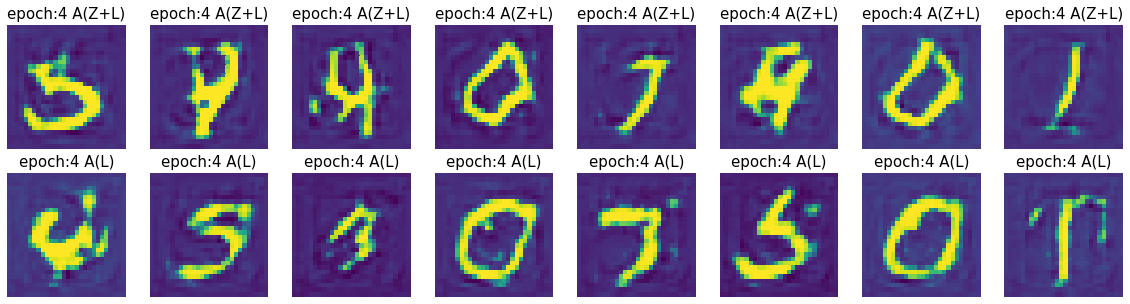

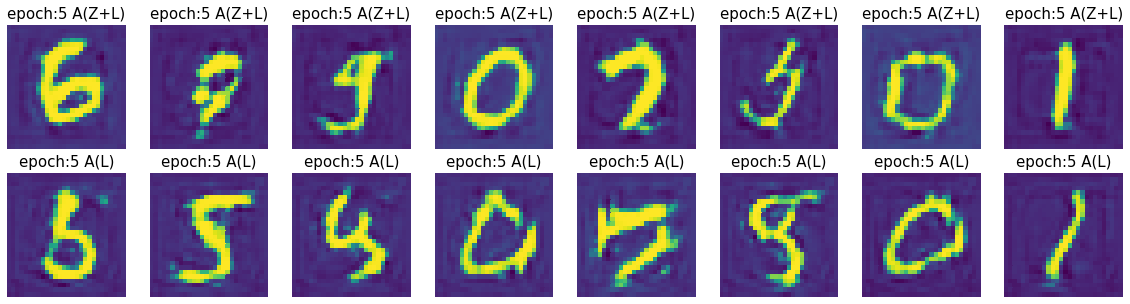

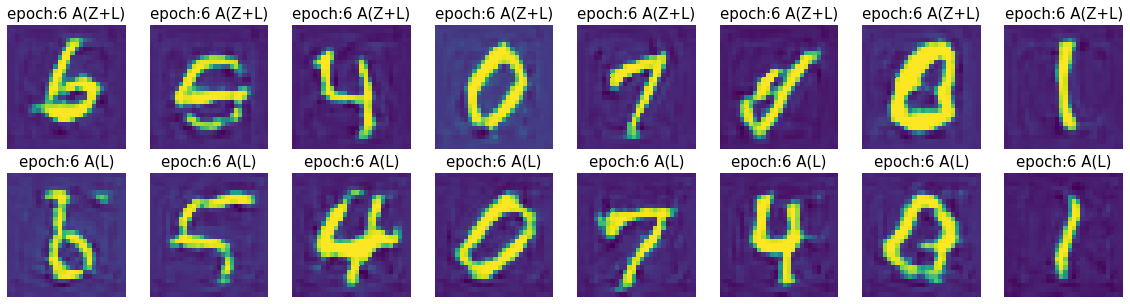

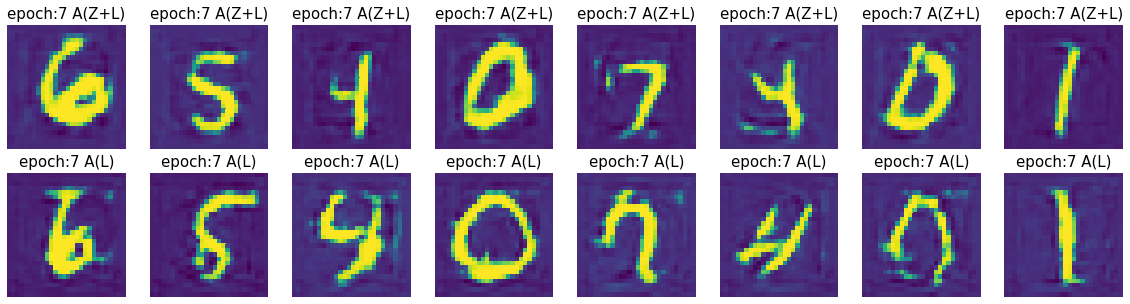

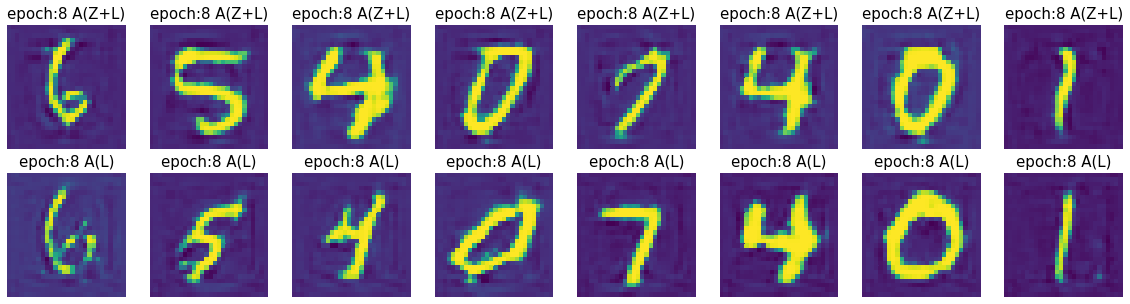

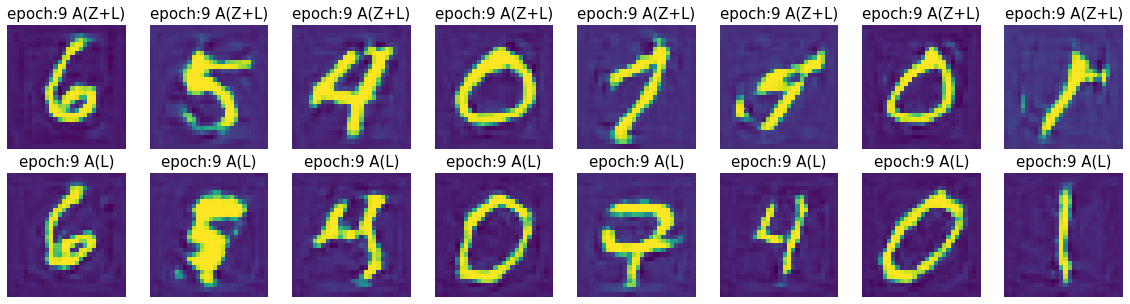

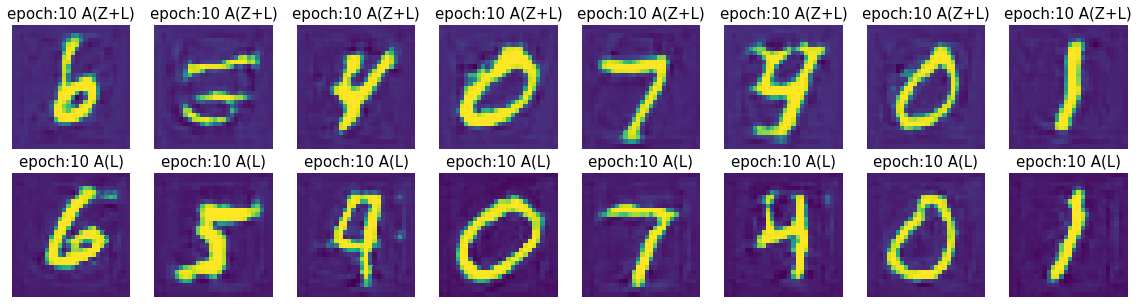

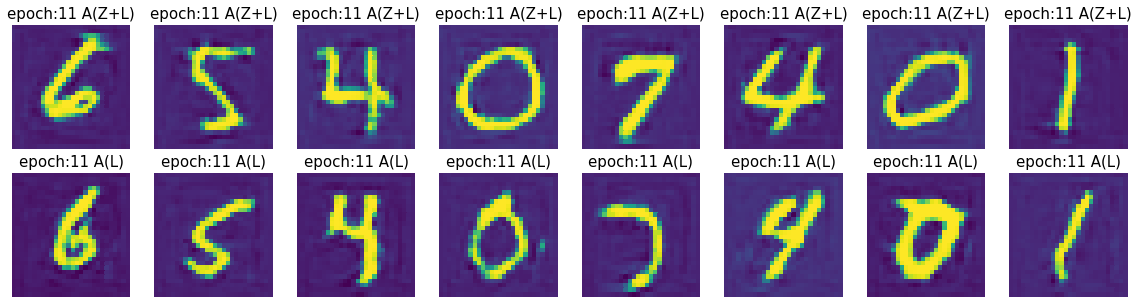

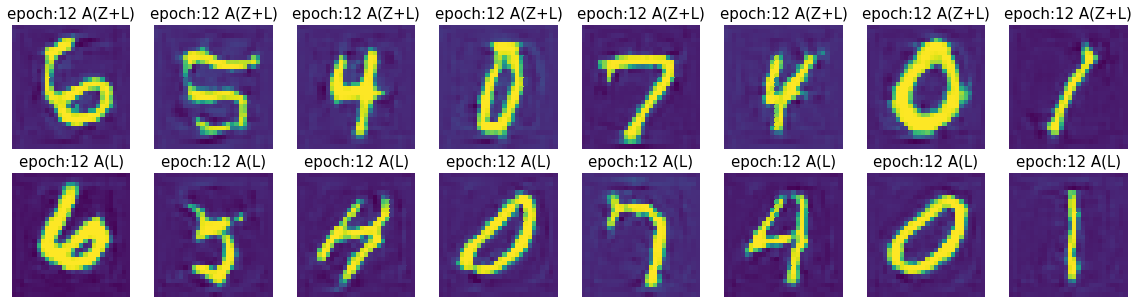

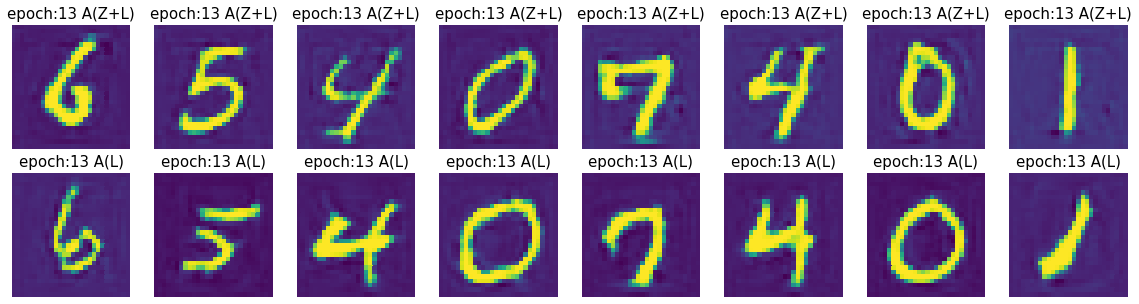

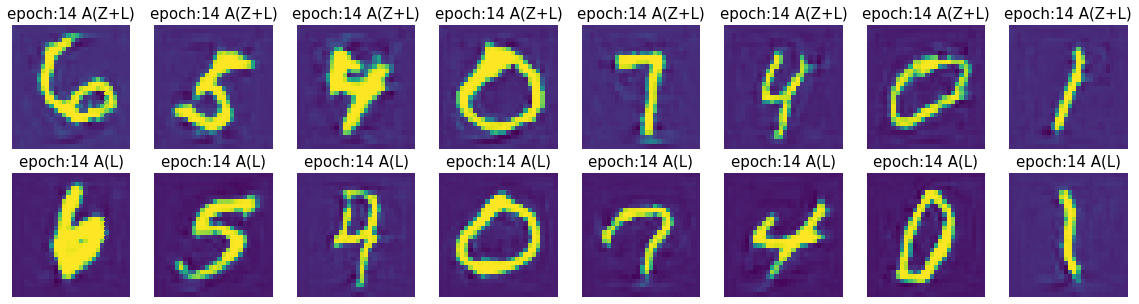

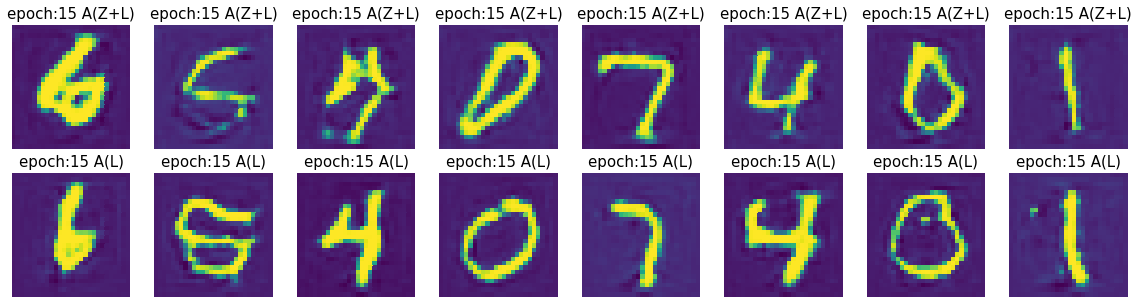

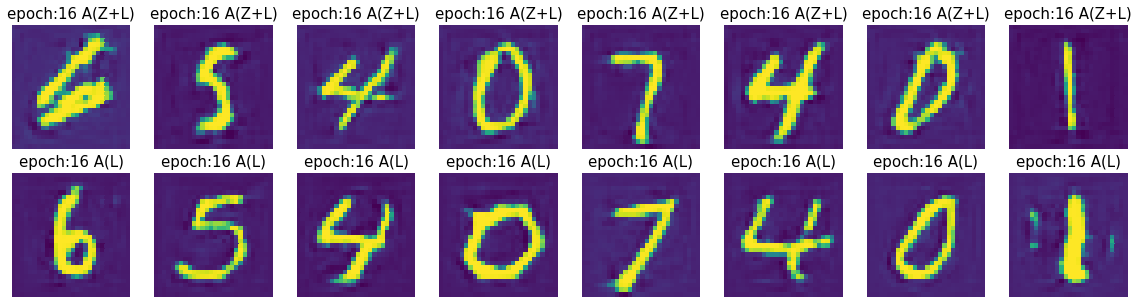

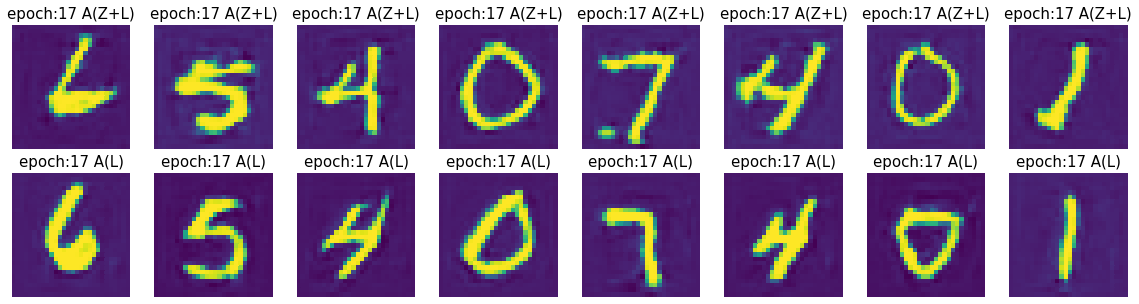

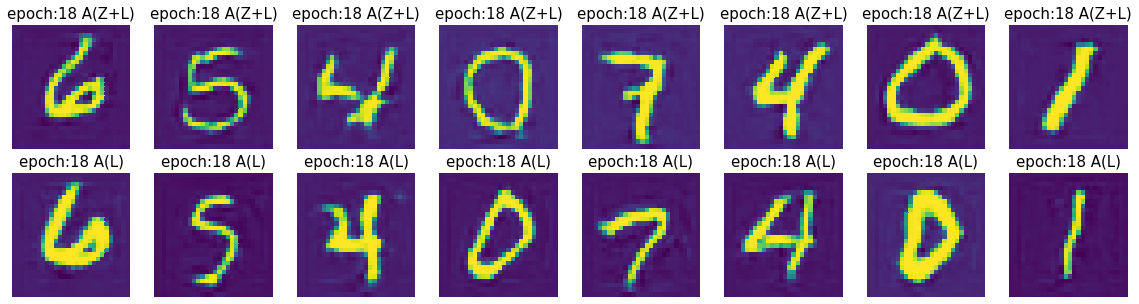

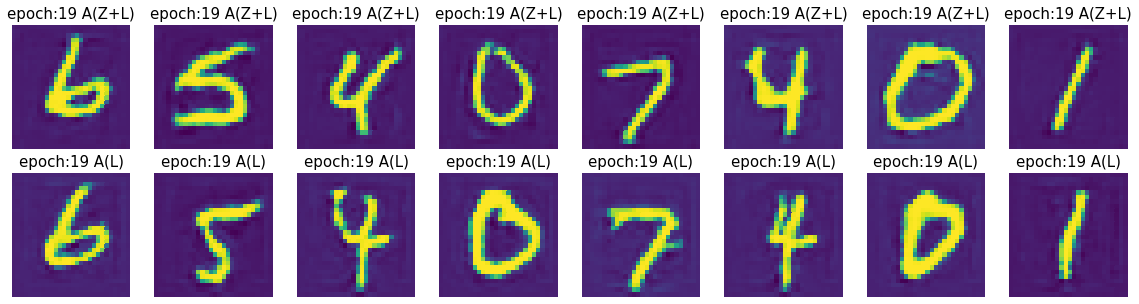

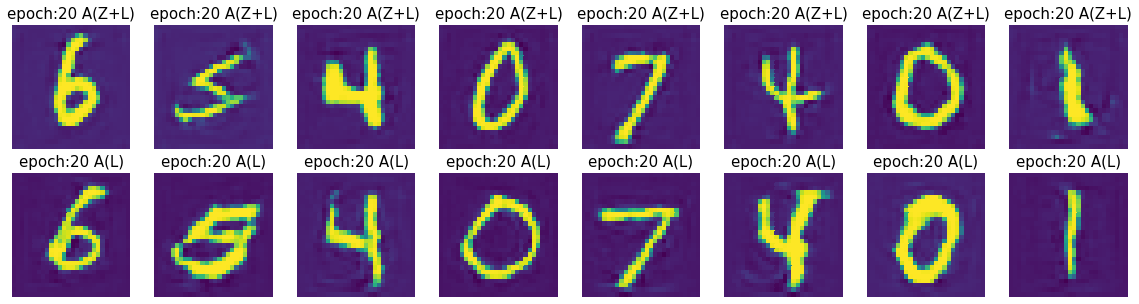

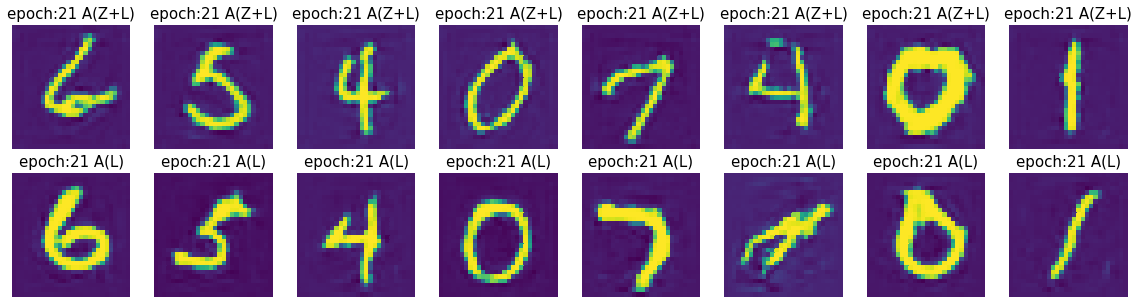

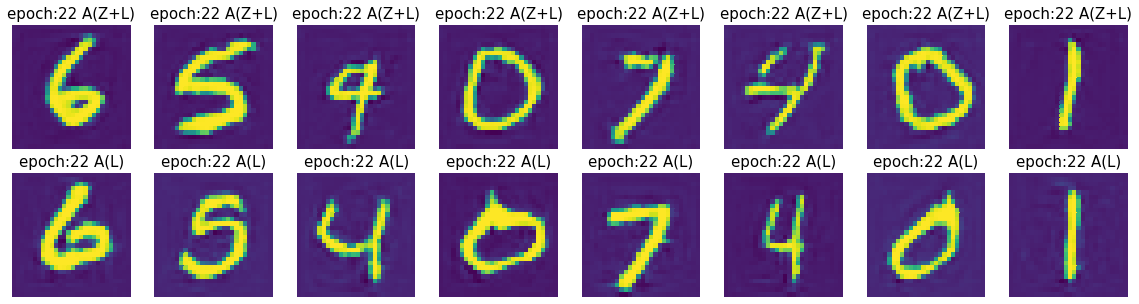

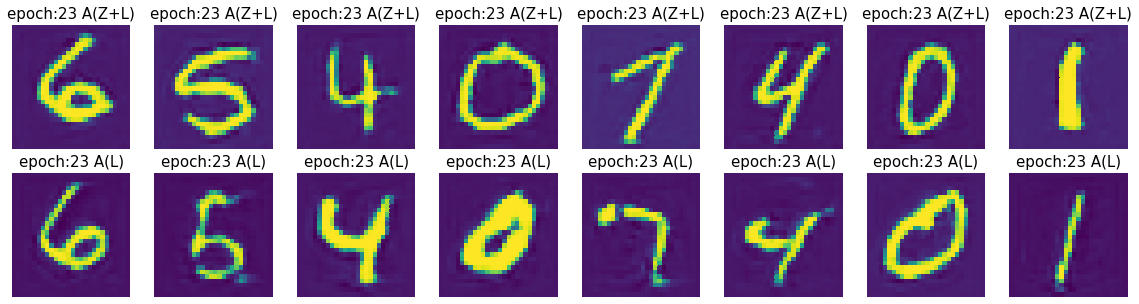

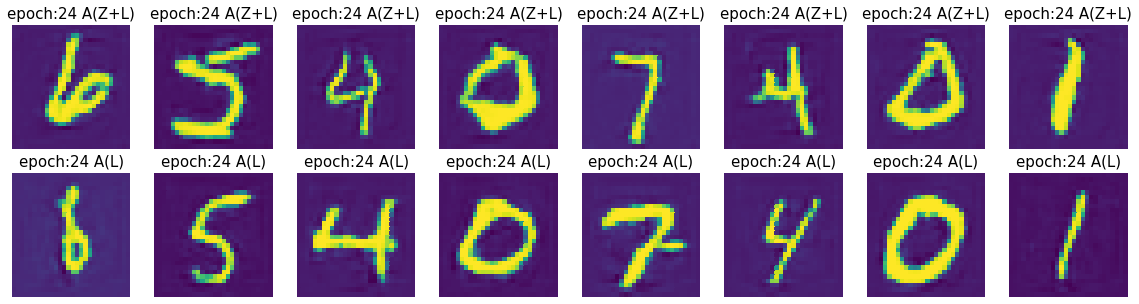

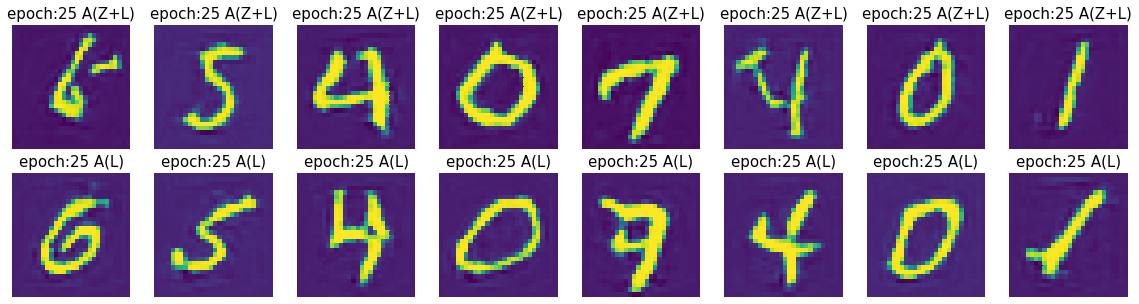

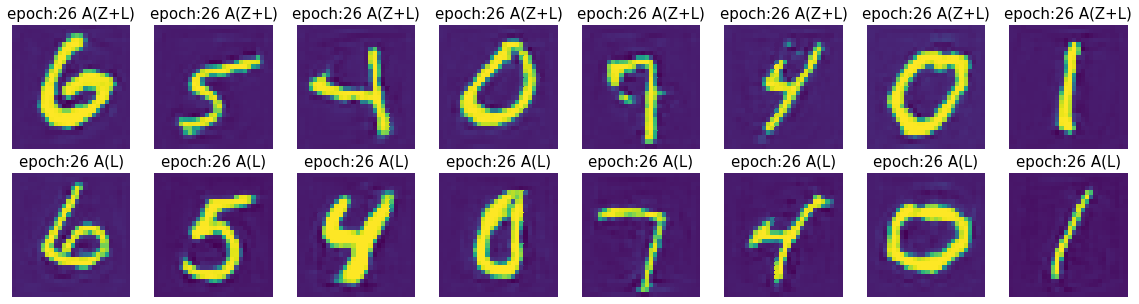

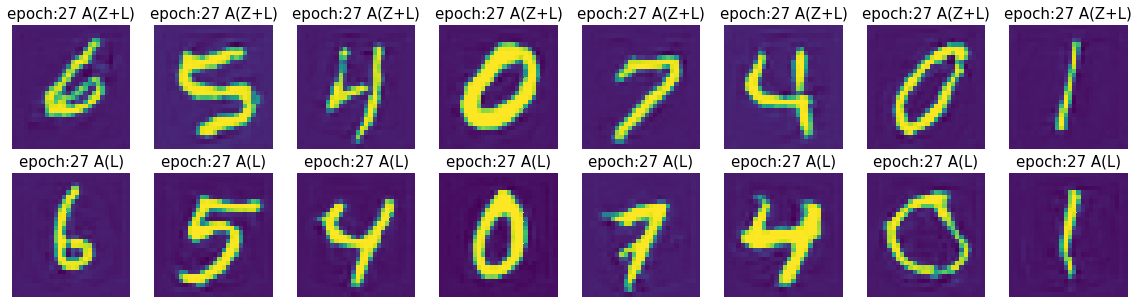

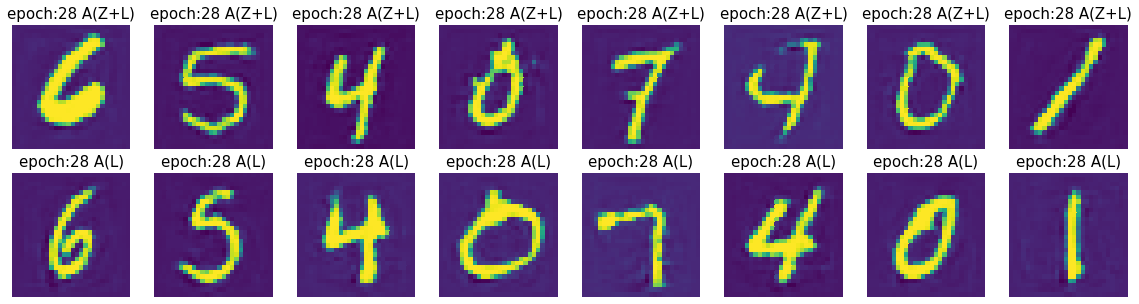

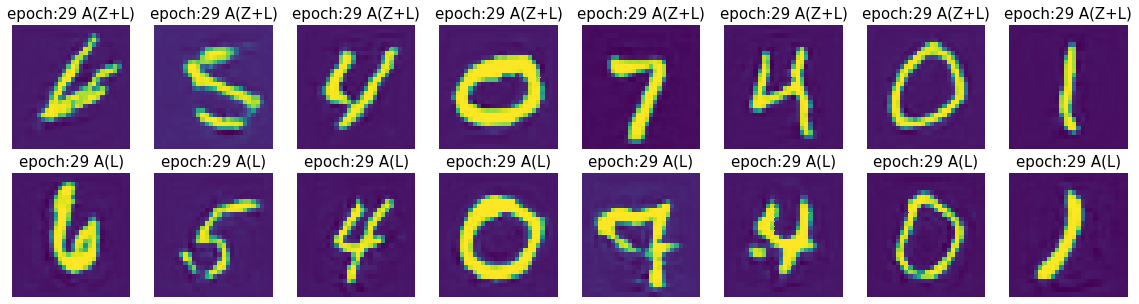

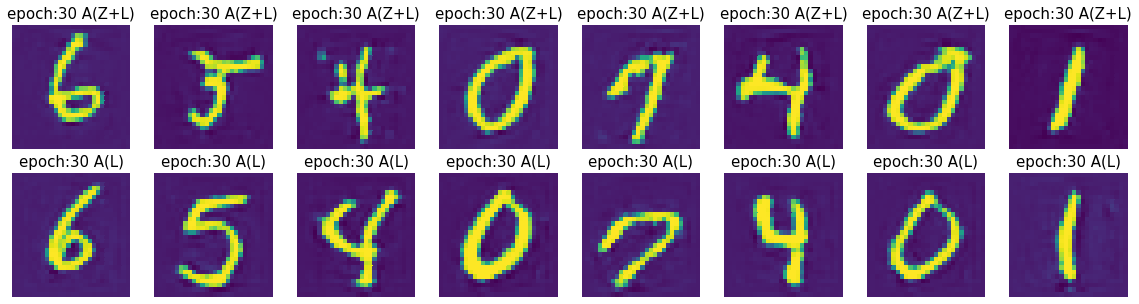

In [10]:
EPOCH = 30
BATCH_SIZE = 64
latent_dim = 100

bce_loss = nn.BCELoss()
cD_p5 = cDis_p5()
cG_p5 = cGen_p5_AZL(noise_dim = latent_dim, label_dim = 32, divided_num = 4 )

cD_p5_AL = cDis_p5()
cG_p5_AL = cGen_p5_AL(noise_dim = latent_dim, label_dim = 32, divided_num = 4 )

if torch.cuda.is_available():
    bce_loss.cuda()
    cD_p5.cuda()
    cG_p5.cuda()
    
    cD_p5_AL.cuda()
    cG_p5_AL.cuda()
    
optim_cD_p5 = torch.optim.Adam(cD_p5.parameters(), lr = 0.0001)
optim_cG_p5 = torch.optim.Adam(cG_p5.parameters(), lr = 0.0001)

optim_cD_p5_AL = torch.optim.Adam(cD_p5_AL.parameters(), lr = 0.0001)
optim_cG_p5_AL = torch.optim.Adam(cG_p5_AL.parameters(), lr = 0.0001)

train_data_dataset = torch.utils.data.TensorDataset(train_data, train_label)
train_dataloader = torch.utils.data.DataLoader(dataset = train_data_dataset, batch_size = BATCH_SIZE, shuffle=True)


D_loss_log = []
G_loss_log = []
D_AL_loss_log = []
G_AL_loss_log = []
log_index = 0
'''
Training gan part
'''
for epoch in range(EPOCH):
    for n, (data, label) in enumerate(train_dataloader):
        real_valid = torch.ones(data.size(0))
        fake_valid = torch.zeros(data.size(0))
        z = torch.randn(data.size(0), latent_dim)
        real_data = data
        real_label = label
        
        # get emb   [bs, 1] >> [bs, emb_len]
        real_label_emb = positional_encoding_no_seq(ori_pos = (real_label.reshape(len(real_label), 1)).data.numpy(), 
                                                    emb_len = 32, d_model = 512) 
        
        real_label_emb = torch.from_numpy(real_label_emb).type(torch.FloatTensor)
        
        if torch.cuda.is_available():
            real_valid = real_valid.cuda()
            fake_valid = fake_valid.cuda()
            z = z.cuda()
            real_data = real_data.cuda()
            real_label = real_label.cuda()
            real_label_emb = real_label_emb.cuda()
            
        #    ===== train gen =====
        #   G for atten(noise, label)
        optim_cG_p5.zero_grad()
        fake_data  = cG_p5(z, real_label_emb) # use real label
        
        cG_loss = bce_loss( cD_p5(fake_data, real_label_emb), real_valid) # judge fake img is real
        cG_loss.backward()
        optim_cG_p5.step()
        
        #   G for atten(label)
        optim_cG_p5_AL.zero_grad()
        fake_data_AL = cG_p5_AL(z, real_label_emb)
        cG_AL_loss = bce_loss(cD_p5_AL(fake_data_AL, real_label_emb), real_valid)
        cG_AL_loss.backward()
        optim_cG_p5_AL.step()
        
        #    ===== train dis =====
        # (z+L)
        optim_cD_p5.zero_grad()
        real_loss = bce_loss(cD_p5(real_data,          real_label_emb), real_valid) # judge real img is real
        fake_loss = bce_loss(cD_p5(fake_data.detach(), real_label_emb), fake_valid)
        
        cD_loss = (real_loss+fake_loss)/2
        cD_loss.backward()
        optim_cD_p5.step()
        # (L)
        optim_cD_p5_AL.zero_grad()
        real_AL_loss = bce_loss(cD_p5_AL(real_data,             real_label_emb), real_valid)
        fake_AL_loss = bce_loss(cD_p5_AL(fake_data_AL.detach(), real_label_emb), fake_valid)
        cD_AL_loss = (real_AL_loss + fake_AL_loss)/2
        cD_AL_loss.backward()
        optim_cD_p5_AL.step()
        
        if log_index % 50 == 0:
            G_loss_log.append(cG_loss)
            D_loss_log.append(cD_loss)
            
            G_AL_loss_log.append(cG_AL_loss)
            D_AL_loss_log.append(cD_AL_loss)
        log_index += 1
    with torch.no_grad():
        print('\n\nEpoch[{}] >> cG_loss : {:.4f}, cD_loss : {:.4f}'.format(epoch+1, cG_loss.item(), cD_loss.item()))
        print('Epoch[{}] >> cG_AL_loss : {:.4f}, cD_AL_loss : {:.4f}'.format(epoch+1, cG_AL_loss.item(), cD_AL_loss.item()))
        
        # plot sample
        z = torch.randn(8, latent_dim)
        label = test_label[22:30].type(torch.FloatTensor)
        test_label_emb = positional_encoding_no_seq(ori_pos = (label.reshape(len(label), 1)).data.numpy(), 
                                                    emb_len = 32, d_model = 512)
        if device:
            z = z.to(device)
            label = label.to(device)
            test_label_emb = torch.from_numpy(test_label_emb).type(torch.FloatTensor).to(device)

        fake_data = cG_p5(z, test_label_emb)
        fake_data_AL = cG_p5_AL(z, test_label_emb)
        fig, ax = plt.subplots(2, 8, figsize=(20, 5))
        for i in range(8):
            ax[0, i].set_title('epoch:'+str(epoch+1)+ ' A(Z+L)', size=15)
            sns.heatmap(fake_data.data.cpu().numpy()[i,:,:], cbar = False, 
                        xticklabels = False, yticklabels=False, ax = ax[0, i], cmap = 'viridis')
        for i in range(8):
            ax[1, i].set_title('epoch:'+str(epoch+1)+' A(L)', size=15)
            sns.heatmap(fake_data_AL.data.cpu().numpy()[i,:,:], cbar = False, 
                        xticklabels = False, yticklabels=False, ax = ax[1, i], cmap = 'viridis')
        
#-------------------test label ---------------------------
label = test_label[22:30].type(torch.FloatTensor)
print(label[:8])

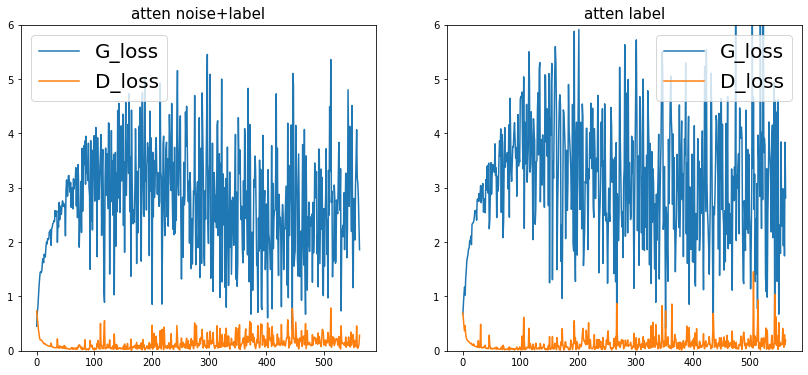

In [11]:
'''
with loss observe
may be difficult
but observe each epoch
atten label is more faster
'''
with torch.no_grad():

    fig, ax = plt.subplots(1, 2, figsize = (14, 6))
    ax[0].set_title('atten noise+label', size = 15)
    ax[0].plot(np.arange(0, len(G_loss_log)), G_loss_log, label='G_loss')
    ax[0].plot(np.arange(0, len(D_loss_log)), D_loss_log, label='D_loss')
    ax[0].set_ylim(0, 6)
    ax[0].legend(fontsize=20)
    
    ax[1].set_title('atten label', size = 15)
    ax[1].plot(np.arange(0, len(G_AL_loss_log)), G_AL_loss_log, label='G_loss')
    ax[1].plot(np.arange(0, len(D_AL_loss_log)), D_AL_loss_log, label='D_loss')
    ax[1].set_ylim(0, 6)
    ax[1].legend(fontsize=20)

/home/nclab62159/anaconda3/lib/python3.6/site-packages/torchvision/datasets/mnist.py:53: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
/home/nclab62159/anaconda3/lib/python3.6/site-packages/torchvision/datasets/mnist.py:43: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")


tensor([9, 0, 0, 3, 0, 2, 7, 2, 5, 5, 0, 9, 5, 5, 7, 9])


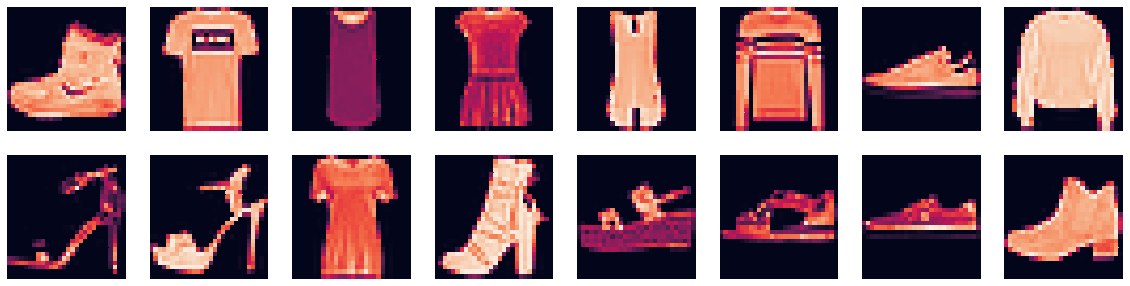

In [5]:
# fashine MNIST
FashionMNIST_train_data = torchvision.datasets.FashionMNIST(root='./data', train=True, 
                         download = False, transform = transforms.Compose([transforms.ToTensor()]))
train_Fashion_data = FashionMNIST_train_data.train_data
train_Fashion_data = train_Fashion_data.type(torch.FloatTensor)/255
train_Fashion_label = FashionMNIST_train_data.train_labels
#
FashionMNIST_test_data = torchvision.datasets.FashionMNIST(root='./data', train=False, 
                                    download = False, transform = transforms.Compose([transforms.ToTensor()]))
test_Fashion_data = FashionMNIST_test_data.train_data
test_Fashion_data = test_Fashion_data.type(torch.FloatTensor)/255
test_Fashion_label = FashionMNIST_test_data.train_labels


data = train_Fashion_data[:16,:,:]
print(train_Fashion_label[:16])
fig, ax = plt.subplots(2, 8, figsize=(20, 5))
for i in range(8):
    sns.heatmap(data.data.cpu().numpy()[i,:,:], cbar = False, 
                    xticklabels = False, yticklabels=False, ax = ax[0, i] )
    sns.heatmap(data.data.cpu().numpy()[i+8,:,:], cbar = False, 
                    xticklabels = False, yticklabels=False, ax = ax[1, i])
    




Epoch[1] >> cG_loss : 2.6468, cD_loss : 0.1143
Epoch[1] >> cG_AL_loss : 2.3134, cD_AL_loss : 0.0813


Epoch[2] >> cG_loss : 3.1385, cD_loss : 0.0449
Epoch[2] >> cG_AL_loss : 2.9770, cD_AL_loss : 0.0420


Epoch[3] >> cG_loss : 3.6314, cD_loss : 0.0335
Epoch[3] >> cG_AL_loss : 3.0074, cD_AL_loss : 0.0357


Epoch[4] >> cG_loss : 3.6620, cD_loss : 0.0347
Epoch[4] >> cG_AL_loss : 1.9535, cD_AL_loss : 0.1045


Epoch[5] >> cG_loss : 2.4387, cD_loss : 0.0920
Epoch[5] >> cG_AL_loss : 3.1287, cD_AL_loss : 0.0373


Epoch[6] >> cG_loss : 2.6527, cD_loss : 0.0671
Epoch[6] >> cG_AL_loss : 2.8562, cD_AL_loss : 0.0543


Epoch[7] >> cG_loss : 3.2230, cD_loss : 0.0473
Epoch[7] >> cG_AL_loss : 3.9577, cD_AL_loss : 0.0577


Epoch[8] >> cG_loss : 5.2403, cD_loss : 0.0166
Epoch[8] >> cG_AL_loss : 3.6180, cD_AL_loss : 0.0260


Epoch[9] >> cG_loss : 5.4770, cD_loss : 0.0695
Epoch[9] >> cG_AL_loss : 3.2437, cD_AL_loss : 0.0314


Epoch[10] >> cG_loss : 5.9072, cD_loss : 0.0040
Epoch[10] >> cG_AL_loss : 4.7795

/home/nclab62159/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:115: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).




Epoch[22] >> cG_loss : 7.7436, cD_loss : 0.0621
Epoch[22] >> cG_AL_loss : 3.0751, cD_AL_loss : 0.0419


Epoch[23] >> cG_loss : 4.8168, cD_loss : 0.0135
Epoch[23] >> cG_AL_loss : 4.0909, cD_AL_loss : 0.0312


Epoch[24] >> cG_loss : 5.4355, cD_loss : 0.0097
Epoch[24] >> cG_AL_loss : 1.7050, cD_AL_loss : 0.1669


Epoch[25] >> cG_loss : 3.7852, cD_loss : 0.0680
Epoch[25] >> cG_AL_loss : 4.3651, cD_AL_loss : 0.0341


Epoch[26] >> cG_loss : 4.5242, cD_loss : 0.0656
Epoch[26] >> cG_AL_loss : 2.0161, cD_AL_loss : 0.1678


Epoch[27] >> cG_loss : 8.1409, cD_loss : 0.0021
Epoch[27] >> cG_AL_loss : 1.4616, cD_AL_loss : 0.3443


Epoch[28] >> cG_loss : 6.7962, cD_loss : 0.0222
Epoch[28] >> cG_AL_loss : 6.2249, cD_AL_loss : 0.2068


Epoch[29] >> cG_loss : 5.3077, cD_loss : 0.2468
Epoch[29] >> cG_AL_loss : 4.3277, cD_AL_loss : 0.0331


Epoch[30] >> cG_loss : 5.5289, cD_loss : 0.0340
Epoch[30] >> cG_AL_loss : 5.2741, cD_AL_loss : 0.0862
tensor([4., 5., 7., 3., 4., 1., 2., 4.])


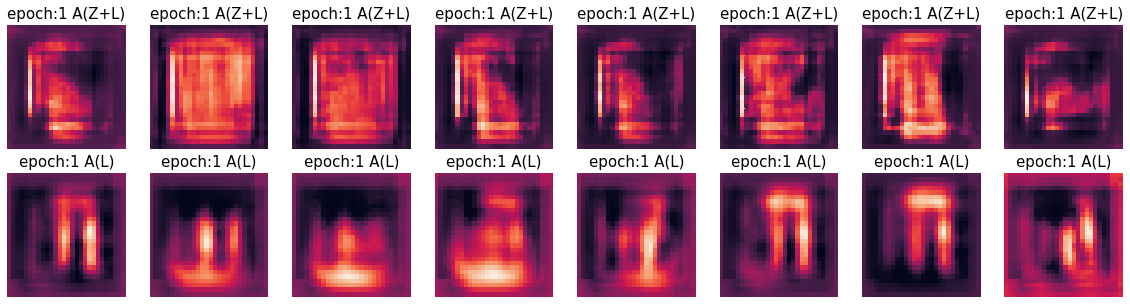

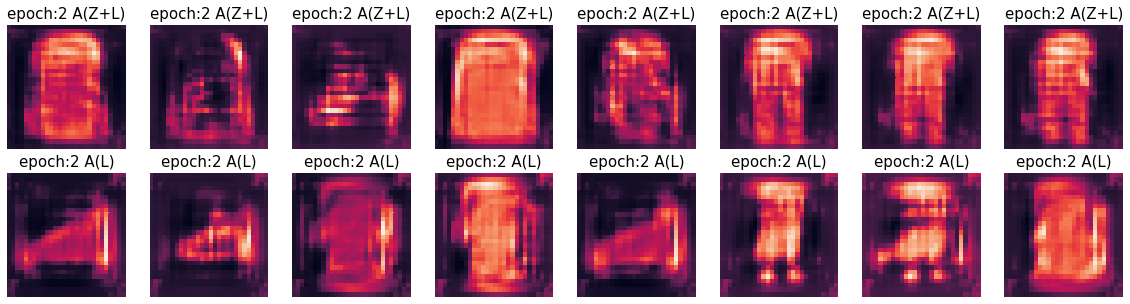

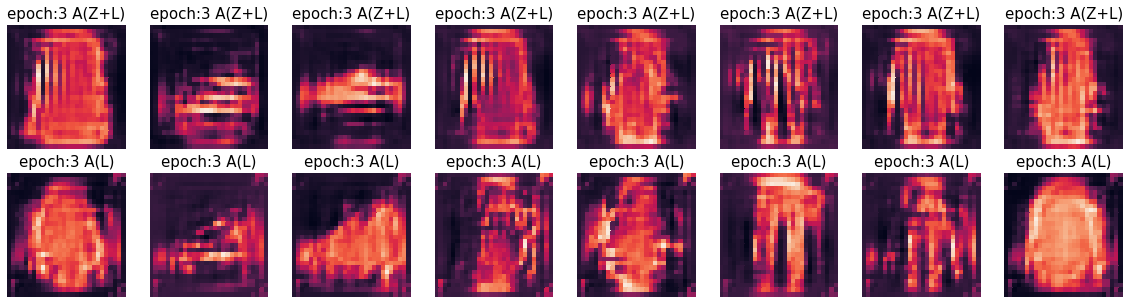

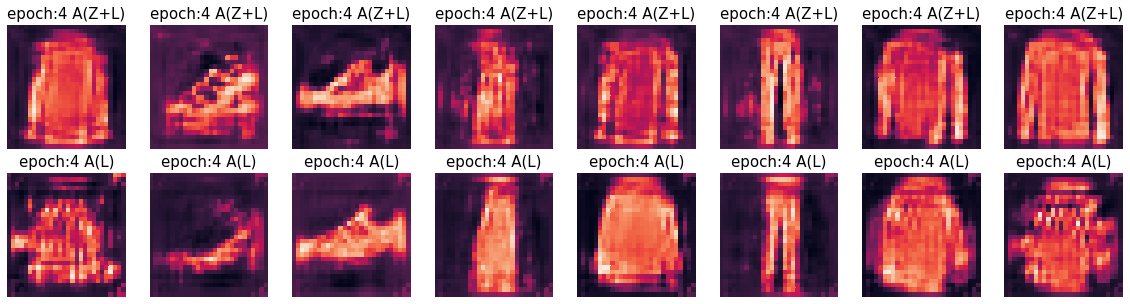

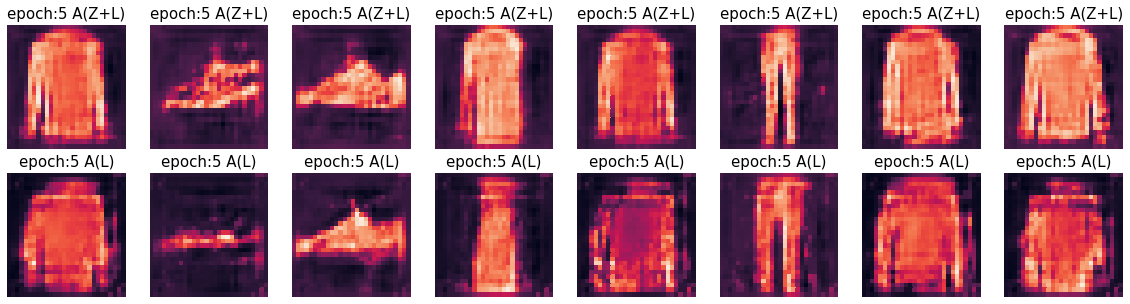

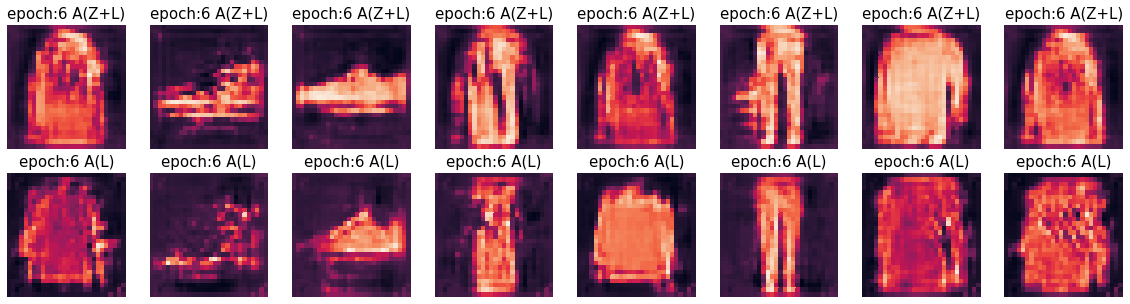

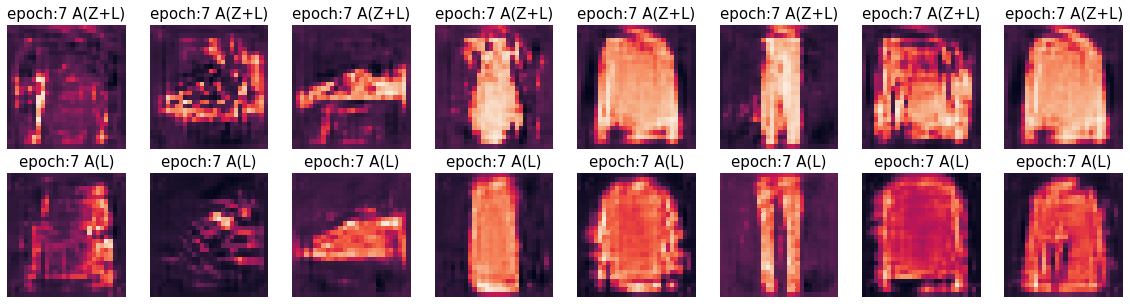

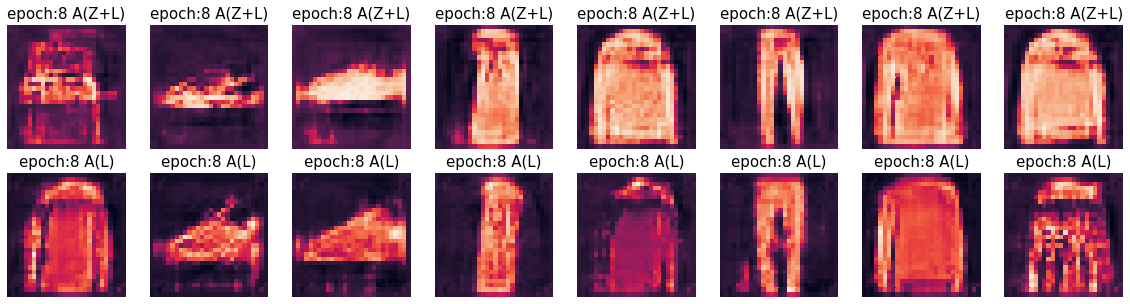

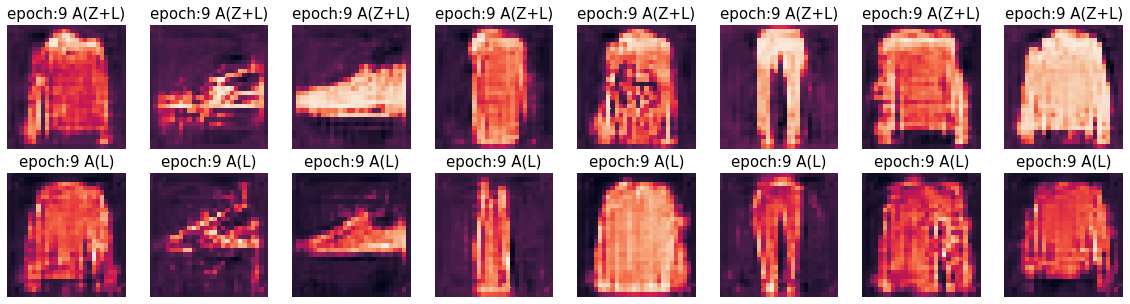

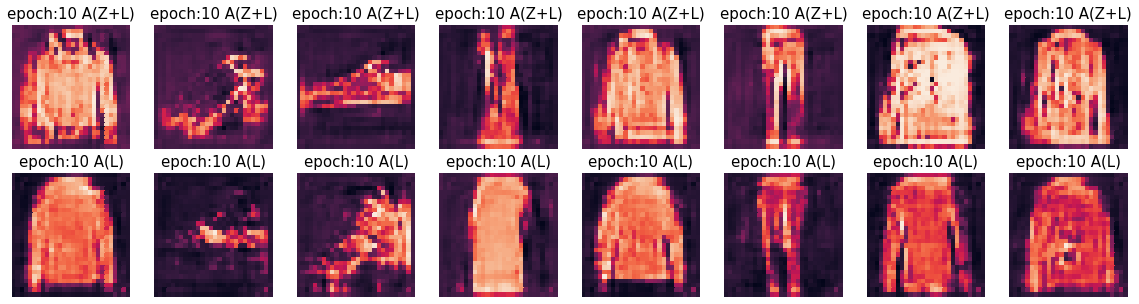

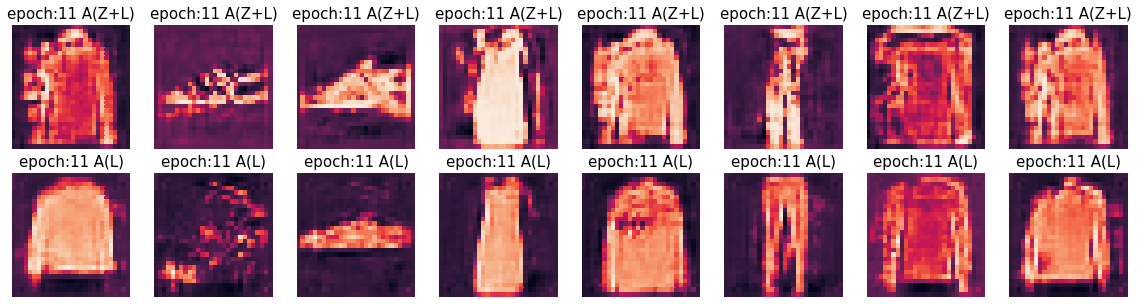

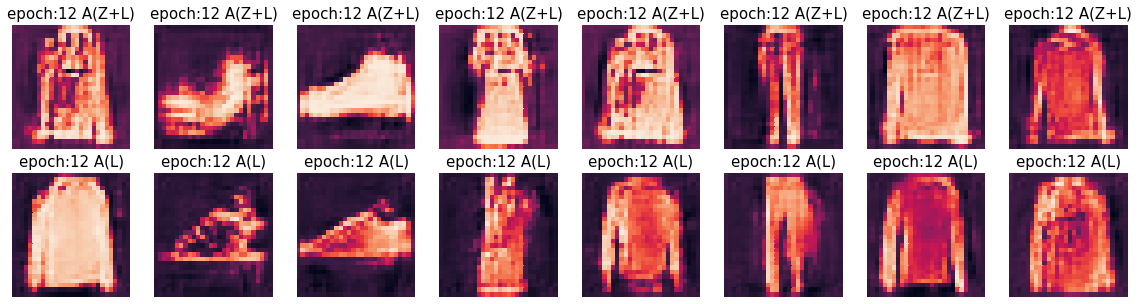

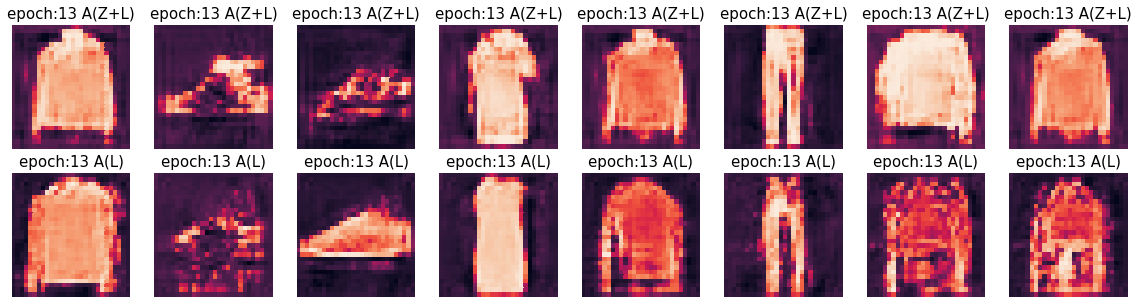

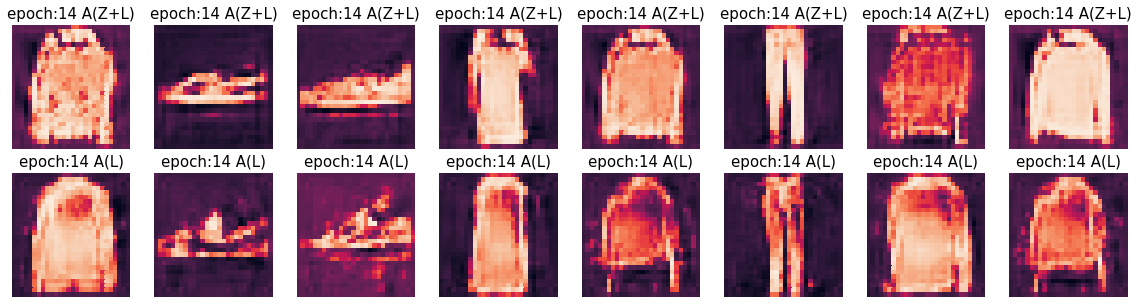

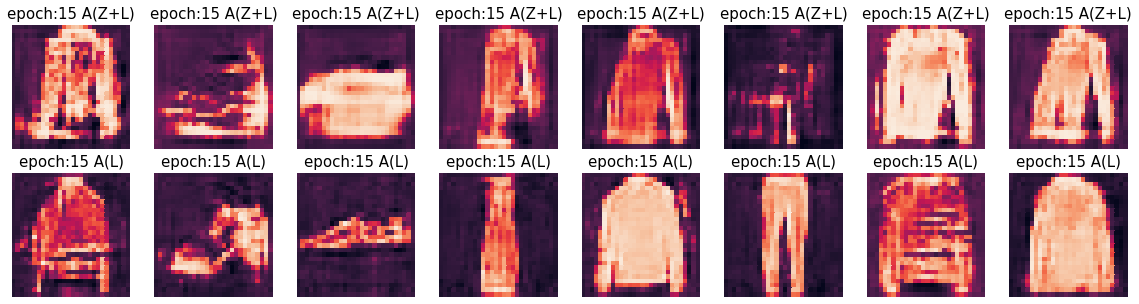

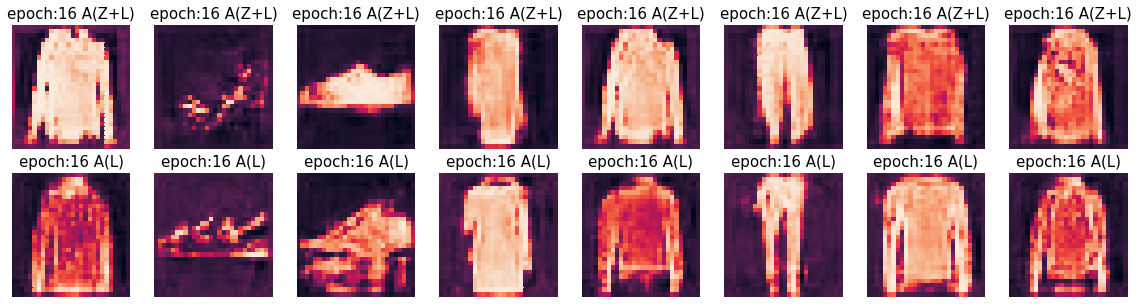

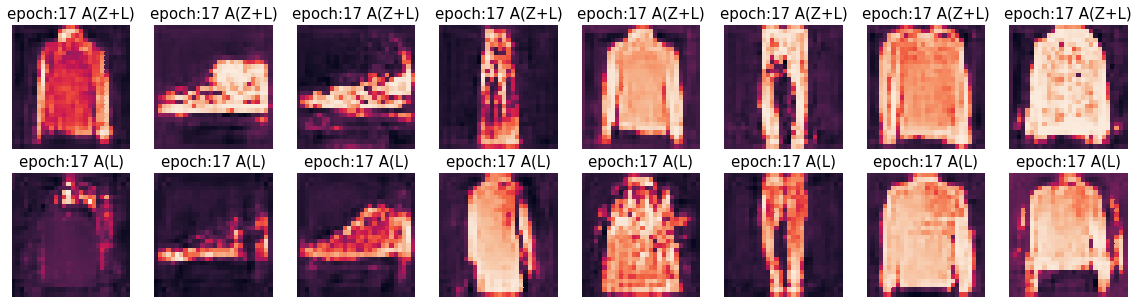

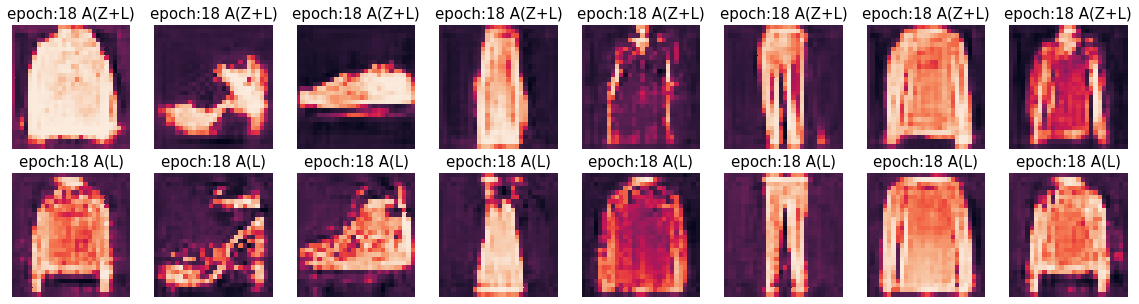

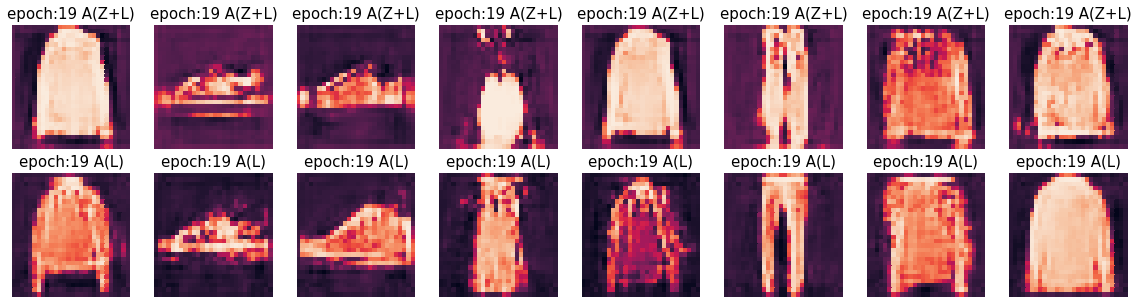

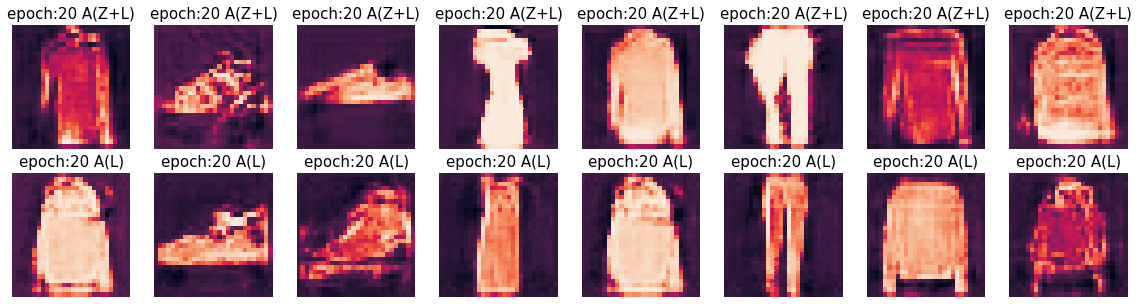

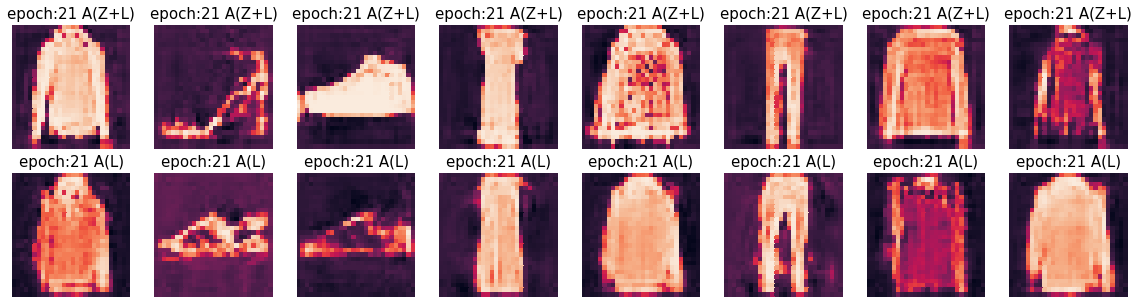

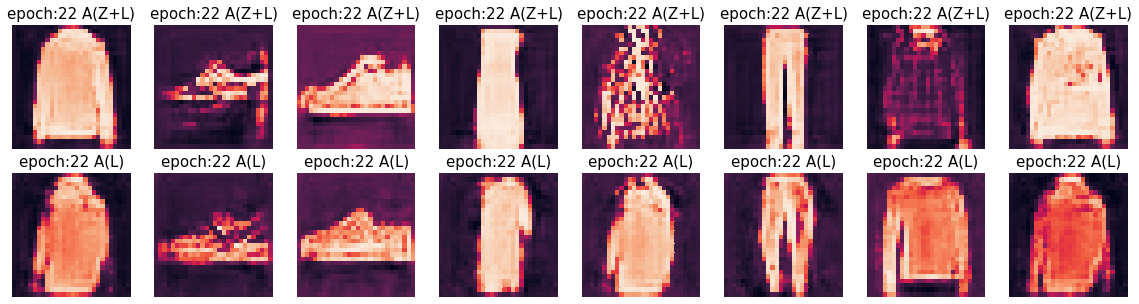

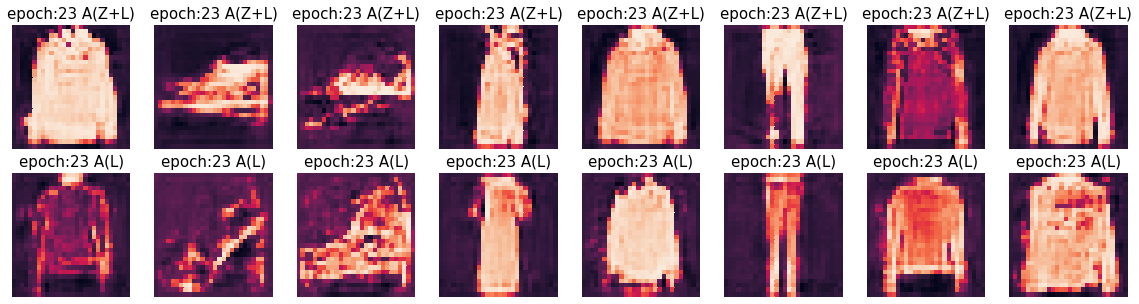

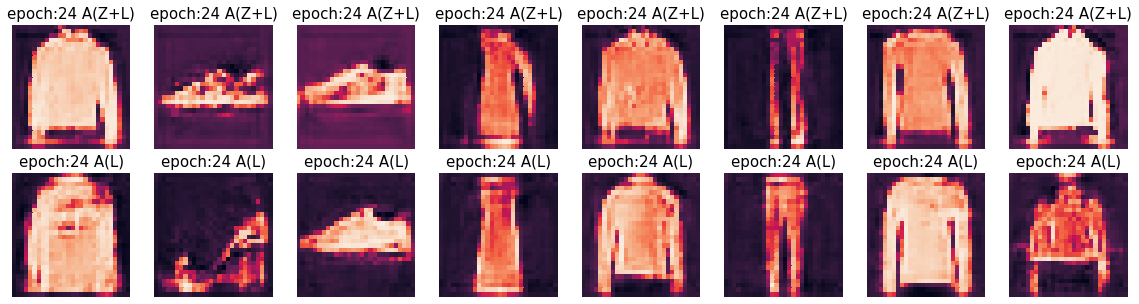

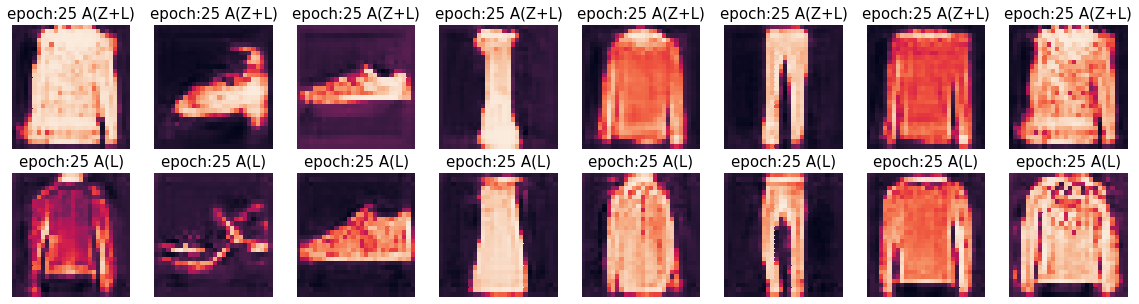

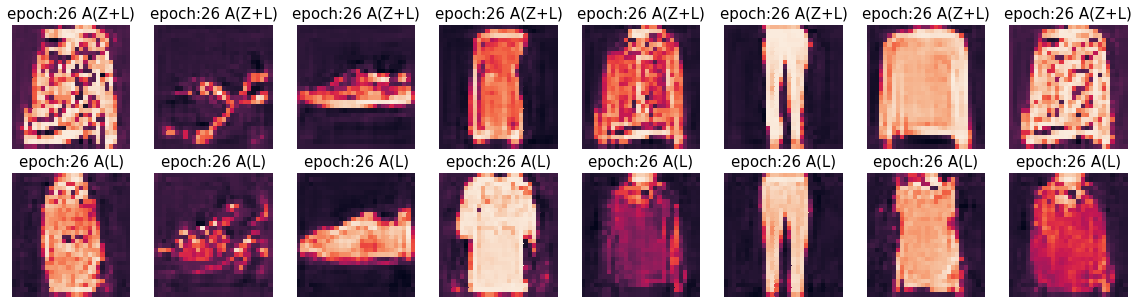

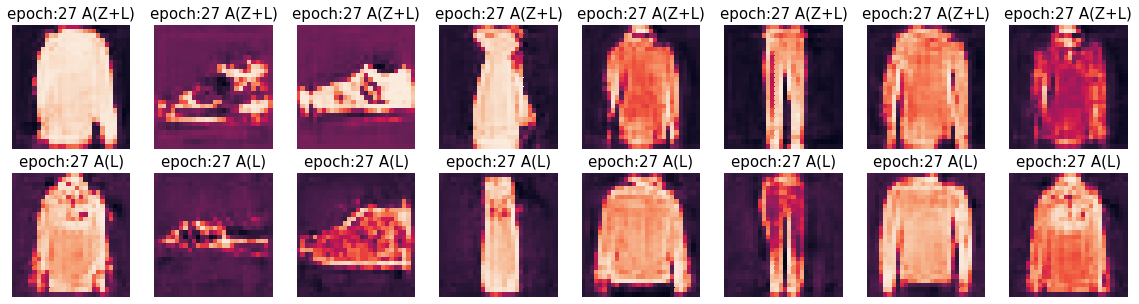

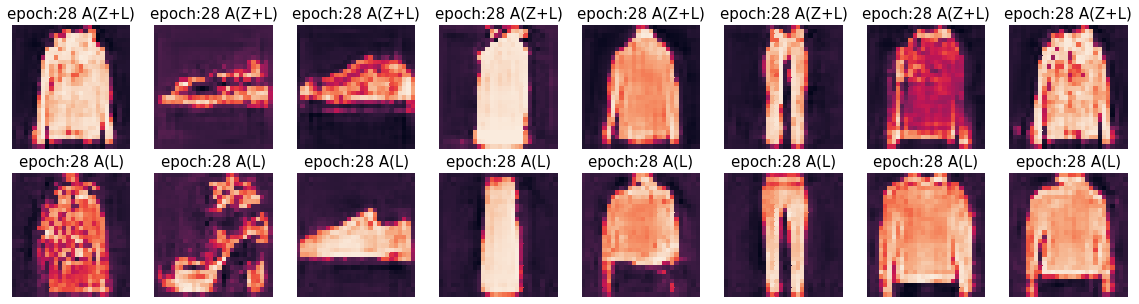

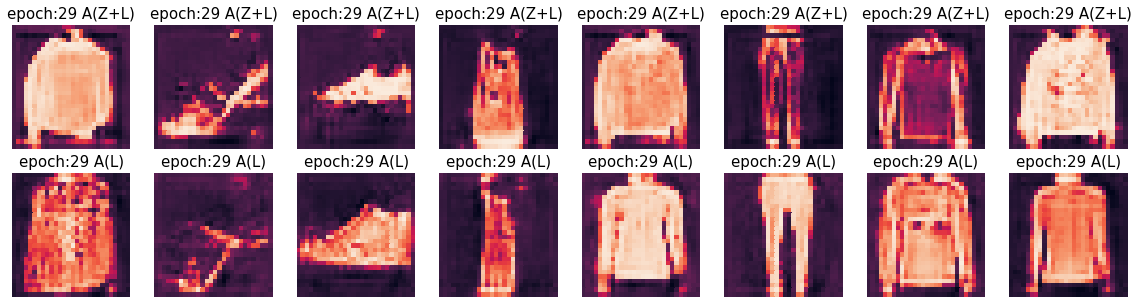

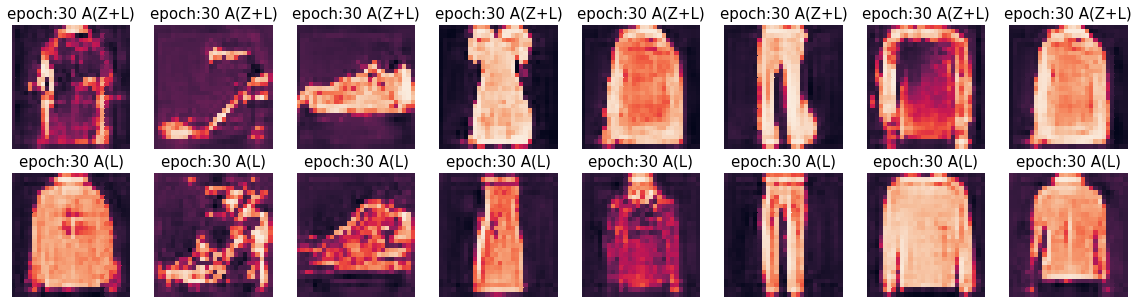

In [7]:
EPOCH = 30
BATCH_SIZE = 64
latent_dim = 100

bce_loss = nn.BCELoss()
cD_p5 = cDis_p5()
cG_p5 = cGen_p5_AZL(noise_dim = latent_dim, label_dim = 32, divided_num = 4 )

cD_p5_AL = cDis_p5()
cG_p5_AL = cGen_p5_AL(noise_dim = latent_dim, label_dim = 32, divided_num = 4 )

if torch.cuda.is_available():
    bce_loss.cuda()
    cD_p5.cuda()
    cG_p5.cuda()
    
    cD_p5_AL.cuda()
    cG_p5_AL.cuda()
    
optim_cD_p5 = torch.optim.Adam(cD_p5.parameters(), lr = 0.0001)
optim_cG_p5 = torch.optim.Adam(cG_p5.parameters(), lr = 0.0001)

optim_cD_p5_AL = torch.optim.Adam(cD_p5_AL.parameters(), lr = 0.0001)
optim_cG_p5_AL = torch.optim.Adam(cG_p5_AL.parameters(), lr = 0.0001)

D_loss_log = []
G_loss_log = []
D_AL_loss_log = []
G_AL_loss_log = []
log_index = 0
'''
Training Fashine MNIST
'''
train_Fashion_data_dataset = torch.utils.data.TensorDataset(train_Fashion_data, train_Fashion_label)
train_Fashion_dataloader = torch.utils.data.DataLoader(dataset = train_Fashion_data_dataset, batch_size = BATCH_SIZE, shuffle=True)

for epoch in range(EPOCH):
    for n, (data, label) in enumerate(train_Fashion_dataloader):
        real_valid = torch.ones(data.size(0))
        fake_valid = torch.zeros(data.size(0))
        z = torch.randn(data.size(0), latent_dim)
        real_data = data
        real_label = label
        
        # get emb   [bs, 1] >> [bs, emb_len]
        real_label_emb = positional_encoding_no_seq(ori_pos = (real_label.reshape(len(real_label), 1)).data.numpy(), 
                                                    emb_len = 32, d_model = 512) 
        
        real_label_emb = torch.from_numpy(real_label_emb).type(torch.FloatTensor)
        
        if torch.cuda.is_available():
            real_valid = real_valid.cuda()
            fake_valid = fake_valid.cuda()
            z = z.cuda()
            real_data = real_data.cuda()
            real_label = real_label.cuda()
            real_label_emb = real_label_emb.cuda()
            
        #    ===== train gen =====
        #   G for atten(noise, label)
        optim_cG_p5.zero_grad()
        fake_data  = cG_p5(z, real_label_emb) # use real label
        
        cG_loss = bce_loss( cD_p5(fake_data, real_label_emb), real_valid) # judge fake img is real
        cG_loss.backward()
        optim_cG_p5.step()
        
        #   G for atten(label)
        optim_cG_p5_AL.zero_grad()
        fake_data_AL = cG_p5_AL(z, real_label_emb)
        cG_AL_loss = bce_loss(cD_p5_AL(fake_data_AL, real_label_emb), real_valid)
        cG_AL_loss.backward()
        optim_cG_p5_AL.step()
        
        #    ===== train dis =====
        # (z+L)
        optim_cD_p5.zero_grad()
        real_loss = bce_loss(cD_p5(real_data,          real_label_emb), real_valid) # judge real img is real
        fake_loss = bce_loss(cD_p5(fake_data.detach(), real_label_emb), fake_valid)
        
        cD_loss = (real_loss+fake_loss)/2
        cD_loss.backward()
        optim_cD_p5.step()
        # (L)
        optim_cD_p5_AL.zero_grad()
        real_AL_loss = bce_loss(cD_p5_AL(real_data,             real_label_emb), real_valid)
        fake_AL_loss = bce_loss(cD_p5_AL(fake_data_AL.detach(), real_label_emb), fake_valid)
        cD_AL_loss = (real_AL_loss + fake_AL_loss)/2
        cD_AL_loss.backward()
        optim_cD_p5_AL.step()
        
        if log_index % 50 == 0:
            G_loss_log.append(cG_loss)
            D_loss_log.append(cD_loss)
            
            G_AL_loss_log.append(cG_AL_loss)
            D_AL_loss_log.append(cD_AL_loss)
        log_index += 1
    with torch.no_grad():
        print('\n\nEpoch[{}] >> cG_loss : {:.4f}, cD_loss : {:.4f}'.format(epoch+1, cG_loss.item(), cD_loss.item()))
        print('Epoch[{}] >> cG_AL_loss : {:.4f}, cD_AL_loss : {:.4f}'.format(epoch+1, cG_AL_loss.item(), cD_AL_loss.item()))
        
        # plot sample
        z = torch.randn(8, latent_dim)
        label = test_Fashion_label[10:18].type(torch.FloatTensor)
        test_label_emb = positional_encoding_no_seq(ori_pos = (label.reshape(len(label), 1)).data.numpy(), 
                                                    emb_len = 32, d_model = 512)
        if device:
            z = z.to(device)
            label = label.to(device)
            test_label_emb = torch.from_numpy(test_label_emb).type(torch.FloatTensor).to(device)

        fake_data = cG_p5(z, test_label_emb)
        fake_data_AL = cG_p5_AL(z, test_label_emb)
        fig, ax = plt.subplots(2, 8, figsize=(20, 5))
        for i in range(8):
            ax[0, i].set_title('epoch:'+str(epoch+1)+ ' A(Z+L)', size=15)
            sns.heatmap(fake_data.data.cpu().numpy()[i,:,:], cbar = False, 
                        xticklabels = False, yticklabels=False, ax = ax[0, i])
        for i in range(8):
            ax[1, i].set_title('epoch:'+str(epoch+1)+' A(L)', size=15)
            sns.heatmap(fake_data_AL.data.cpu().numpy()[i,:,:], cbar = False, 
                        xticklabels = False, yticklabels=False, ax = ax[1, i])
        
#-------------------test label ---------------------------
label = test_Fashion_label[10:18].type(torch.FloatTensor)
print(label[:8])